# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-06 11:19:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [       <=>          ] 201.24M  30.6MB/s    in 7.3s    

2023-10-06 11:19:30 (27.4 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

In [ ]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse

model = Ridge(alpha=0.1)
rmse_for_model = mse

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

np.sqrt(rmse_for_model(y_test, y_pred))

9.510160718781293

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
best_rmse_metric = np.sqrt(np.sum((y_test - np.mean(y_test)) ** 2))
best_rmse_metric

2465.7965388619023

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!
model = nn.Sequential(nn.Linear(X_train.shape[1], 1))

In [ ]:
X_train = X_train[:10000]
y_train = y_train[:10000]

In [ ]:
X_test = X_test[:1000]
y_test = y_test[:1000]

In [ ]:
import matplotlib.pyplot as plt

learning_rate = 0.01
num_epochs = 10

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    y_pred = model(torch.from_numpy(X_train).type(torch.float32))
    loss = torch.sqrt(torch.mean((y_pred - torch.from_numpy(y_train)) ** 2))
    train_losses.append(loss.item())

    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
        model.zero_grad()

    with torch.no_grad():
        y_test_pred = model(torch.from_numpy(X_test).type(torch.float32))
        test_loss = torch.sqrt(torch.mean((y_test_pred - torch.from_numpy(y_test)) ** 2))
        test_losses.append(test_loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [1/10], Train Loss: 1998.8887, Test Loss: 1997.5288
Epoch [2/10], Train Loss: 1998.8783, Test Loss: 1997.5184
Epoch [3/10], Train Loss: 1998.8679, Test Loss: 1997.5083
Epoch [4/10], Train Loss: 1998.8575, Test Loss: 1997.4980
Epoch [5/10], Train Loss: 1998.8473, Test Loss: 1997.4878
Epoch [6/10], Train Loss: 1998.8369, Test Loss: 1997.4774
Epoch [7/10], Train Loss: 1998.8264, Test Loss: 1997.4673
Epoch [8/10], Train Loss: 1998.8162, Test Loss: 1997.4570
Epoch [9/10], Train Loss: 1998.8058, Test Loss: 1997.4468
Epoch [10/10], Train Loss: 1998.7955, Test Loss: 1997.4364


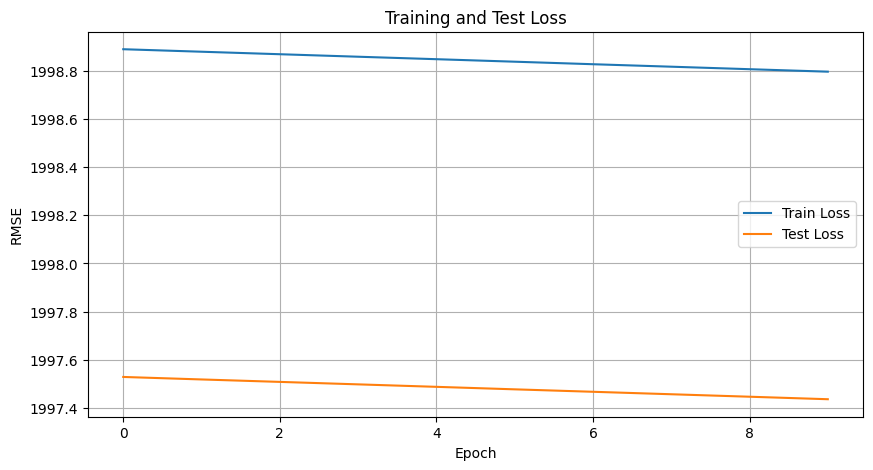

In [ ]:
plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Test Loss')

# plt.subplot(1, 2, 2)
# with torch.no_grad():
#     predicted = model(torch.from_numpy(X_test).type(torch.float32))
# plt.scatter(X_test, y_test, label='True Data')
# plt.plot(X_test, predicted, label='Predictions', color='r')
# plt.legend()
# plt.xlabel('X')
# plt.ylabel('y')
# plt.title('True Data vs. Predictions')

plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

set_random_seed(42)

df = pd.read_csv('data.txt.zip', header=None)
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

Так как все GPU-часы у меня уже потрачены, то буду использовать только первые 20000 данных из датасета.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[:20000], y[:20000], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# применим минимакс скалер для таргета
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).T[0]
y_test = scaler.transform(y_test.reshape(-1, 1)).T[0]

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

input_size = X_train.shape[1]
output_size = 1

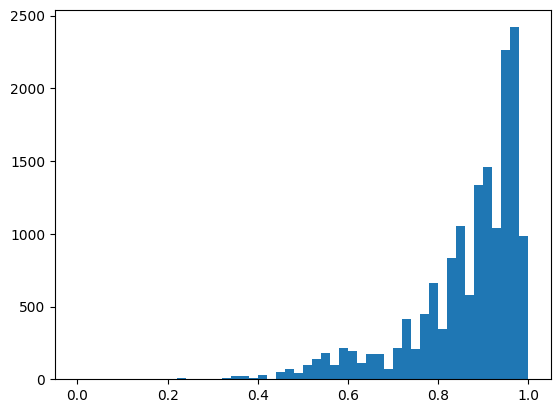

In [ ]:
plt.hist(y_train, bins=50);

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size: int, output_size: int=1):
        super(NeuralNet, self).__init__()
        self.block = nn.Sequential(nn.Linear(input_size, 2 * input_size),
                                    nn.ReLU(),
                                    nn.LayerNorm(2 * input_size),
                                    # nn.Dropout(0.2),

                                    nn.Linear(2 * input_size, 4 * input_size),
                                    nn.ReLU(),
                                    nn.LayerNorm(4 * input_size),
                                    nn.Dropout(0.2),

                                    # nn.Linear(4 * input_size, 8 * input_size),
                                    # nn.ReLU(),
                                    # nn.LayerNorm(8 * input_size),
                                    # nn.Dropout(0.2),

                                    # nn.Linear(8 * input_size, 4 * input_size),
                                    # nn.LayerNorm(4 * input_size),
                                    # nn.Dropout(0.2),
                                    # nn.ReLU(),
                                    # nn.LayerNorm(4 * input_size),

                                    nn.Linear(4 * input_size, 2 * input_size),
                                    nn.LayerNorm(2 * input_size),
                                    # nn.Dropout(0.2),
                                    nn.ReLU(),
                                    nn.LayerNorm(2 * input_size),

                                    nn.Linear(2 * input_size, output_size),
                                    # nn.Hardtanh(0, 1)
                                    nn.ReLU()
                                    )

    def forward(self, x):
        x = self.block(x)
        return x

In [ ]:
model = NeuralNet(input_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# просто функция для расчета RMSE для предикта и таргета, переведенных именно в года
my_loss = lambda y_pred, y_test: np.sqrt(np.mean((scaler.inverse_transform(y_pred.T[0].detach().numpy().reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1))) ** 2))

In [ ]:
num_epochs = 1000
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_loss = my_loss(model(X_train), y_train)
        test_loss = my_loss(model(X_test), y_test)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    if (epoch + 1) % 1 == 0: # выводим каждую эпоху для большей наглядности резулльтата
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


  0%|          | 1/1000 [00:00<09:18,  1.79it/s]

Epoch [1/1000], Train Loss: 14.6547, Test Loss: 14.7241


  0%|          | 2/1000 [00:01<09:24,  1.77it/s]

Epoch [2/1000], Train Loss: 11.3671, Test Loss: 11.4323


  0%|          | 3/1000 [00:01<09:28,  1.75it/s]

Epoch [3/1000], Train Loss: 10.6943, Test Loss: 10.6095


  0%|          | 4/1000 [00:02<09:26,  1.76it/s]

Epoch [4/1000], Train Loss: 11.0462, Test Loss: 11.0430


  0%|          | 5/1000 [00:02<09:30,  1.74it/s]

Epoch [5/1000], Train Loss: 10.6100, Test Loss: 10.6538


  1%|          | 6/1000 [00:03<09:30,  1.74it/s]

Epoch [6/1000], Train Loss: 10.5166, Test Loss: 10.6461


  1%|          | 7/1000 [00:03<09:21,  1.77it/s]

Epoch [7/1000], Train Loss: 10.8640, Test Loss: 10.9278


  1%|          | 8/1000 [00:04<09:20,  1.77it/s]

Epoch [8/1000], Train Loss: 11.0884, Test Loss: 11.2086


  1%|          | 9/1000 [00:05<09:22,  1.76it/s]

Epoch [9/1000], Train Loss: 10.1557, Test Loss: 10.2737


  1%|          | 10/1000 [00:05<09:19,  1.77it/s]

Epoch [10/1000], Train Loss: 10.2772, Test Loss: 10.3804


  1%|          | 11/1000 [00:06<09:25,  1.75it/s]

Epoch [11/1000], Train Loss: 10.1747, Test Loss: 10.2629


  1%|          | 12/1000 [00:06<09:26,  1.74it/s]

Epoch [12/1000], Train Loss: 9.6971, Test Loss: 9.6599


  1%|▏         | 13/1000 [00:07<09:31,  1.73it/s]

Epoch [13/1000], Train Loss: 9.8630, Test Loss: 10.0734


  1%|▏         | 14/1000 [00:07<09:23,  1.75it/s]

Epoch [14/1000], Train Loss: 10.1506, Test Loss: 10.3159


  2%|▏         | 15/1000 [00:08<09:20,  1.76it/s]

Epoch [15/1000], Train Loss: 9.6759, Test Loss: 9.9261


  2%|▏         | 16/1000 [00:09<09:30,  1.72it/s]

Epoch [16/1000], Train Loss: 9.6362, Test Loss: 9.8087


  2%|▏         | 17/1000 [00:09<10:01,  1.64it/s]

Epoch [17/1000], Train Loss: 9.7428, Test Loss: 9.9359


  2%|▏         | 18/1000 [00:10<10:56,  1.50it/s]

Epoch [18/1000], Train Loss: 9.9015, Test Loss: 10.1955


  2%|▏         | 19/1000 [00:11<10:56,  1.49it/s]

Epoch [19/1000], Train Loss: 10.0862, Test Loss: 10.3843


  2%|▏         | 20/1000 [00:11<10:24,  1.57it/s]

Epoch [20/1000], Train Loss: 9.7614, Test Loss: 9.8815


  2%|▏         | 21/1000 [00:12<09:59,  1.63it/s]

Epoch [21/1000], Train Loss: 9.5200, Test Loss: 9.7791


  2%|▏         | 22/1000 [00:13<09:51,  1.65it/s]

Epoch [22/1000], Train Loss: 9.8121, Test Loss: 9.9935


  2%|▏         | 23/1000 [00:13<09:43,  1.67it/s]

Epoch [23/1000], Train Loss: 10.0134, Test Loss: 10.3190


  2%|▏         | 24/1000 [00:14<09:37,  1.69it/s]

Epoch [24/1000], Train Loss: 9.6928, Test Loss: 9.7784


  2%|▎         | 25/1000 [00:14<09:32,  1.70it/s]

Epoch [25/1000], Train Loss: 9.4957, Test Loss: 9.6643


  3%|▎         | 26/1000 [00:15<09:23,  1.73it/s]

Epoch [26/1000], Train Loss: 9.3237, Test Loss: 9.6657


  3%|▎         | 27/1000 [00:15<09:21,  1.73it/s]

Epoch [27/1000], Train Loss: 10.9293, Test Loss: 11.2611


  3%|▎         | 28/1000 [00:16<09:13,  1.76it/s]

Epoch [28/1000], Train Loss: 9.5805, Test Loss: 9.9330


  3%|▎         | 29/1000 [00:17<09:15,  1.75it/s]

Epoch [29/1000], Train Loss: 9.0043, Test Loss: 9.5017


  3%|▎         | 30/1000 [00:17<09:08,  1.77it/s]

Epoch [30/1000], Train Loss: 9.5003, Test Loss: 9.9465


  3%|▎         | 31/1000 [00:18<09:11,  1.76it/s]

Epoch [31/1000], Train Loss: 10.0006, Test Loss: 10.3069


  3%|▎         | 32/1000 [00:18<09:17,  1.74it/s]

Epoch [32/1000], Train Loss: 9.0782, Test Loss: 9.4508


  3%|▎         | 33/1000 [00:19<09:14,  1.74it/s]

Epoch [33/1000], Train Loss: 8.8682, Test Loss: 9.2741


  3%|▎         | 34/1000 [00:19<09:17,  1.73it/s]

Epoch [34/1000], Train Loss: 9.3212, Test Loss: 9.7735


  4%|▎         | 35/1000 [00:20<09:13,  1.74it/s]

Epoch [35/1000], Train Loss: 9.0808, Test Loss: 9.3746


  4%|▎         | 36/1000 [00:21<09:06,  1.76it/s]

Epoch [36/1000], Train Loss: 9.4203, Test Loss: 9.9813


  4%|▎         | 37/1000 [00:21<10:06,  1.59it/s]

Epoch [37/1000], Train Loss: 9.6267, Test Loss: 10.0723


  4%|▍         | 38/1000 [00:22<10:45,  1.49it/s]

Epoch [38/1000], Train Loss: 9.4622, Test Loss: 9.9803


  4%|▍         | 39/1000 [00:23<10:30,  1.52it/s]

Epoch [39/1000], Train Loss: 9.9640, Test Loss: 10.2380


  4%|▍         | 40/1000 [00:23<10:07,  1.58it/s]

Epoch [40/1000], Train Loss: 9.0694, Test Loss: 9.7208


  4%|▍         | 41/1000 [00:24<09:49,  1.63it/s]

Epoch [41/1000], Train Loss: 9.4255, Test Loss: 9.9000


  4%|▍         | 42/1000 [00:24<09:31,  1.68it/s]

Epoch [42/1000], Train Loss: 9.3375, Test Loss: 10.0160


  4%|▍         | 43/1000 [00:25<09:27,  1.69it/s]

Epoch [43/1000], Train Loss: 9.7266, Test Loss: 10.3311


  4%|▍         | 44/1000 [00:26<09:19,  1.71it/s]

Epoch [44/1000], Train Loss: 8.8487, Test Loss: 9.4375


  4%|▍         | 45/1000 [00:26<09:06,  1.75it/s]

Epoch [45/1000], Train Loss: 9.0016, Test Loss: 9.5902


  5%|▍         | 46/1000 [00:27<08:58,  1.77it/s]

Epoch [46/1000], Train Loss: 10.4452, Test Loss: 11.1613


  5%|▍         | 47/1000 [00:27<08:59,  1.77it/s]

Epoch [47/1000], Train Loss: 9.2203, Test Loss: 9.6946


  5%|▍         | 48/1000 [00:28<08:50,  1.80it/s]

Epoch [48/1000], Train Loss: 8.6195, Test Loss: 9.2637


  5%|▍         | 49/1000 [00:28<08:50,  1.79it/s]

Epoch [49/1000], Train Loss: 8.9200, Test Loss: 9.6139


  5%|▌         | 50/1000 [00:29<08:49,  1.80it/s]

Epoch [50/1000], Train Loss: 10.1754, Test Loss: 10.9572


  5%|▌         | 51/1000 [00:29<08:49,  1.79it/s]

Epoch [51/1000], Train Loss: 8.8629, Test Loss: 9.6094


  5%|▌         | 52/1000 [00:30<08:55,  1.77it/s]

Epoch [52/1000], Train Loss: 8.7520, Test Loss: 9.5048


  5%|▌         | 53/1000 [00:31<08:53,  1.77it/s]

Epoch [53/1000], Train Loss: 8.8374, Test Loss: 9.5418


  5%|▌         | 54/1000 [00:31<08:56,  1.76it/s]

Epoch [54/1000], Train Loss: 9.0742, Test Loss: 9.8031


  6%|▌         | 55/1000 [00:32<08:59,  1.75it/s]

Epoch [55/1000], Train Loss: 9.1296, Test Loss: 9.9175


  6%|▌         | 56/1000 [00:32<09:06,  1.73it/s]

Epoch [56/1000], Train Loss: 8.4065, Test Loss: 9.2115


  6%|▌         | 57/1000 [00:33<10:00,  1.57it/s]

Epoch [57/1000], Train Loss: 9.0071, Test Loss: 9.6358


  6%|▌         | 58/1000 [00:34<10:49,  1.45it/s]

Epoch [58/1000], Train Loss: 8.4813, Test Loss: 9.1651


  6%|▌         | 59/1000 [00:34<10:15,  1.53it/s]

Epoch [59/1000], Train Loss: 9.0916, Test Loss: 9.5838


  6%|▌         | 60/1000 [00:35<09:50,  1.59it/s]

Epoch [60/1000], Train Loss: 8.8427, Test Loss: 9.8067


  6%|▌         | 61/1000 [00:36<09:34,  1.63it/s]

Epoch [61/1000], Train Loss: 8.5024, Test Loss: 9.2935


  6%|▌         | 62/1000 [00:36<09:23,  1.66it/s]

Epoch [62/1000], Train Loss: 8.6722, Test Loss: 9.5460


  6%|▋         | 63/1000 [00:37<09:12,  1.70it/s]

Epoch [63/1000], Train Loss: 8.7528, Test Loss: 9.6509


  6%|▋         | 64/1000 [00:37<08:59,  1.73it/s]

Epoch [64/1000], Train Loss: 8.4919, Test Loss: 9.4049


  6%|▋         | 65/1000 [00:38<08:59,  1.73it/s]

Epoch [65/1000], Train Loss: 8.6395, Test Loss: 9.3888


  7%|▋         | 66/1000 [00:38<08:51,  1.76it/s]

Epoch [66/1000], Train Loss: 8.5286, Test Loss: 9.4287


  7%|▋         | 67/1000 [00:39<08:56,  1.74it/s]

Epoch [67/1000], Train Loss: 8.8607, Test Loss: 9.7861


  7%|▋         | 68/1000 [00:40<08:55,  1.74it/s]

Epoch [68/1000], Train Loss: 8.6625, Test Loss: 9.5994


  7%|▋         | 69/1000 [00:40<08:49,  1.76it/s]

Epoch [69/1000], Train Loss: 8.7814, Test Loss: 9.8744


  7%|▋         | 70/1000 [00:41<08:42,  1.78it/s]

Epoch [70/1000], Train Loss: 8.9799, Test Loss: 9.9644


  7%|▋         | 71/1000 [00:41<08:49,  1.76it/s]

Epoch [71/1000], Train Loss: 10.1351, Test Loss: 11.0892


  7%|▋         | 72/1000 [00:42<08:49,  1.75it/s]

Epoch [72/1000], Train Loss: 8.3964, Test Loss: 9.5432


  7%|▋         | 73/1000 [00:42<08:48,  1.75it/s]

Epoch [73/1000], Train Loss: 9.6359, Test Loss: 10.7542


  7%|▋         | 74/1000 [00:43<09:01,  1.71it/s]

Epoch [74/1000], Train Loss: 8.6300, Test Loss: 9.7749


  8%|▊         | 75/1000 [00:44<08:58,  1.72it/s]

Epoch [75/1000], Train Loss: 8.9809, Test Loss: 10.0925


  8%|▊         | 76/1000 [00:44<09:12,  1.67it/s]

Epoch [76/1000], Train Loss: 8.5481, Test Loss: 9.7684


  8%|▊         | 77/1000 [00:45<09:44,  1.58it/s]

Epoch [77/1000], Train Loss: 8.6121, Test Loss: 9.6041


  8%|▊         | 78/1000 [00:46<10:21,  1.48it/s]

Epoch [78/1000], Train Loss: 8.5738, Test Loss: 9.5110


  8%|▊         | 79/1000 [00:46<09:44,  1.58it/s]

Epoch [79/1000], Train Loss: 8.1311, Test Loss: 9.1099


  8%|▊         | 80/1000 [00:47<09:19,  1.64it/s]

Epoch [80/1000], Train Loss: 8.4526, Test Loss: 9.6217


  8%|▊         | 81/1000 [00:47<09:08,  1.68it/s]

Epoch [81/1000], Train Loss: 8.5979, Test Loss: 9.9233


  8%|▊         | 82/1000 [00:48<08:54,  1.72it/s]

Epoch [82/1000], Train Loss: 8.7223, Test Loss: 10.0574


  8%|▊         | 83/1000 [00:48<08:51,  1.73it/s]

Epoch [83/1000], Train Loss: 8.5005, Test Loss: 9.6345


  8%|▊         | 84/1000 [00:49<08:43,  1.75it/s]

Epoch [84/1000], Train Loss: 8.3017, Test Loss: 9.4375


  8%|▊         | 85/1000 [00:50<08:34,  1.78it/s]

Epoch [85/1000], Train Loss: 8.1608, Test Loss: 9.4388


  9%|▊         | 86/1000 [00:50<08:38,  1.76it/s]

Epoch [86/1000], Train Loss: 8.3225, Test Loss: 9.6696


  9%|▊         | 87/1000 [00:51<08:32,  1.78it/s]

Epoch [87/1000], Train Loss: 8.4084, Test Loss: 9.7645


  9%|▉         | 88/1000 [00:51<08:33,  1.77it/s]

Epoch [88/1000], Train Loss: 8.5693, Test Loss: 9.8226


  9%|▉         | 89/1000 [00:52<08:37,  1.76it/s]

Epoch [89/1000], Train Loss: 8.3767, Test Loss: 9.7767


  9%|▉         | 90/1000 [00:52<08:36,  1.76it/s]

Epoch [90/1000], Train Loss: 8.3794, Test Loss: 9.6362


  9%|▉         | 91/1000 [00:53<08:36,  1.76it/s]

Epoch [91/1000], Train Loss: 8.8697, Test Loss: 10.1330


  9%|▉         | 92/1000 [00:54<08:30,  1.78it/s]

Epoch [92/1000], Train Loss: 8.8900, Test Loss: 10.2743


  9%|▉         | 93/1000 [00:54<08:30,  1.78it/s]

Epoch [93/1000], Train Loss: 8.2449, Test Loss: 9.5647


  9%|▉         | 94/1000 [00:55<08:30,  1.78it/s]

Epoch [94/1000], Train Loss: 8.4699, Test Loss: 9.8386


 10%|▉         | 95/1000 [00:55<08:33,  1.76it/s]

Epoch [95/1000], Train Loss: 9.3222, Test Loss: 10.7335


 10%|▉         | 96/1000 [00:56<08:54,  1.69it/s]

Epoch [96/1000], Train Loss: 8.2682, Test Loss: 9.5324


 10%|▉         | 97/1000 [00:57<09:41,  1.55it/s]

Epoch [97/1000], Train Loss: 7.7656, Test Loss: 9.3089


 10%|▉         | 98/1000 [00:57<10:15,  1.47it/s]

Epoch [98/1000], Train Loss: 7.7173, Test Loss: 9.1105


 10%|▉         | 99/1000 [00:58<09:41,  1.55it/s]

Epoch [99/1000], Train Loss: 7.8666, Test Loss: 9.1271


 10%|█         | 100/1000 [00:59<09:30,  1.58it/s]

Epoch [100/1000], Train Loss: 7.9015, Test Loss: 9.1730


 10%|█         | 101/1000 [00:59<09:19,  1.61it/s]

Epoch [101/1000], Train Loss: 8.4234, Test Loss: 10.0701


 10%|█         | 102/1000 [01:00<09:00,  1.66it/s]

Epoch [102/1000], Train Loss: 9.1761, Test Loss: 10.6928


 10%|█         | 103/1000 [01:00<08:53,  1.68it/s]

Epoch [103/1000], Train Loss: 8.1310, Test Loss: 9.7781


 10%|█         | 104/1000 [01:01<08:39,  1.73it/s]

Epoch [104/1000], Train Loss: 7.6931, Test Loss: 9.2159


 10%|█         | 105/1000 [01:01<08:29,  1.76it/s]

Epoch [105/1000], Train Loss: 7.9458, Test Loss: 9.6130


 11%|█         | 106/1000 [01:02<08:37,  1.73it/s]

Epoch [106/1000], Train Loss: 7.9139, Test Loss: 9.2840


 11%|█         | 107/1000 [01:03<08:38,  1.72it/s]

Epoch [107/1000], Train Loss: 8.5766, Test Loss: 9.9964


 11%|█         | 108/1000 [01:03<08:33,  1.74it/s]

Epoch [108/1000], Train Loss: 7.6543, Test Loss: 9.0790


 11%|█         | 109/1000 [01:04<08:29,  1.75it/s]

Epoch [109/1000], Train Loss: 8.2727, Test Loss: 10.0251


 11%|█         | 110/1000 [01:04<08:35,  1.73it/s]

Epoch [110/1000], Train Loss: 7.9313, Test Loss: 9.4064


 11%|█         | 111/1000 [01:05<08:30,  1.74it/s]

Epoch [111/1000], Train Loss: 7.5037, Test Loss: 9.1226


 11%|█         | 112/1000 [01:05<08:28,  1.75it/s]

Epoch [112/1000], Train Loss: 7.8798, Test Loss: 9.4134


 11%|█▏        | 113/1000 [01:06<08:25,  1.75it/s]

Epoch [113/1000], Train Loss: 8.4287, Test Loss: 10.1377


 11%|█▏        | 114/1000 [01:07<08:25,  1.75it/s]

Epoch [114/1000], Train Loss: 7.5335, Test Loss: 9.2920


 12%|█▏        | 115/1000 [01:07<08:31,  1.73it/s]

Epoch [115/1000], Train Loss: 7.6340, Test Loss: 9.0485


 12%|█▏        | 116/1000 [01:08<09:17,  1.59it/s]

Epoch [116/1000], Train Loss: 7.6522, Test Loss: 9.1568


 12%|█▏        | 117/1000 [01:09<09:56,  1.48it/s]

Epoch [117/1000], Train Loss: 8.2348, Test Loss: 9.9888


 12%|█▏        | 118/1000 [01:09<09:57,  1.48it/s]

Epoch [118/1000], Train Loss: 8.0380, Test Loss: 9.7018


 12%|█▏        | 119/1000 [01:10<09:27,  1.55it/s]

Epoch [119/1000], Train Loss: 7.7003, Test Loss: 9.4077


 12%|█▏        | 120/1000 [01:11<09:12,  1.59it/s]

Epoch [120/1000], Train Loss: 7.8111, Test Loss: 9.6095


 12%|█▏        | 121/1000 [01:11<09:04,  1.62it/s]

Epoch [121/1000], Train Loss: 7.9330, Test Loss: 9.6153


 12%|█▏        | 122/1000 [01:12<08:47,  1.66it/s]

Epoch [122/1000], Train Loss: 7.9955, Test Loss: 9.8540


 12%|█▏        | 123/1000 [01:12<08:34,  1.70it/s]

Epoch [123/1000], Train Loss: 7.6224, Test Loss: 9.2638


 12%|█▏        | 124/1000 [01:13<08:35,  1.70it/s]

Epoch [124/1000], Train Loss: 8.4239, Test Loss: 10.2685


 12%|█▎        | 125/1000 [01:13<08:34,  1.70it/s]

Epoch [125/1000], Train Loss: 8.0137, Test Loss: 9.9031


 13%|█▎        | 126/1000 [01:14<08:34,  1.70it/s]

Epoch [126/1000], Train Loss: 9.1972, Test Loss: 10.9941


 13%|█▎        | 127/1000 [01:15<08:28,  1.72it/s]

Epoch [127/1000], Train Loss: 7.4722, Test Loss: 9.0850


 13%|█▎        | 128/1000 [01:15<08:18,  1.75it/s]

Epoch [128/1000], Train Loss: 7.8990, Test Loss: 9.7114


 13%|█▎        | 129/1000 [01:16<08:15,  1.76it/s]

Epoch [129/1000], Train Loss: 7.7355, Test Loss: 9.3468


 13%|█▎        | 130/1000 [01:16<08:12,  1.77it/s]

Epoch [130/1000], Train Loss: 8.3006, Test Loss: 10.2417


 13%|█▎        | 131/1000 [01:17<08:08,  1.78it/s]

Epoch [131/1000], Train Loss: 7.3567, Test Loss: 9.1992


 13%|█▎        | 132/1000 [01:17<08:02,  1.80it/s]

Epoch [132/1000], Train Loss: 7.8510, Test Loss: 9.7508


 13%|█▎        | 133/1000 [01:18<07:56,  1.82it/s]

Epoch [133/1000], Train Loss: 7.2218, Test Loss: 9.0458


 13%|█▎        | 134/1000 [01:18<08:00,  1.80it/s]

Epoch [134/1000], Train Loss: 8.6634, Test Loss: 10.3935


 14%|█▎        | 135/1000 [01:19<08:05,  1.78it/s]

Epoch [135/1000], Train Loss: 7.9209, Test Loss: 9.9083


 14%|█▎        | 136/1000 [01:20<09:02,  1.59it/s]

Epoch [136/1000], Train Loss: 7.3801, Test Loss: 9.4465


 14%|█▎        | 137/1000 [01:21<09:45,  1.47it/s]

Epoch [137/1000], Train Loss: 7.9862, Test Loss: 9.8678


 14%|█▍        | 138/1000 [01:21<09:33,  1.50it/s]

Epoch [138/1000], Train Loss: 9.5178, Test Loss: 11.4270


 14%|█▍        | 139/1000 [01:22<10:04,  1.42it/s]

Epoch [139/1000], Train Loss: 8.7503, Test Loss: 10.6309


 14%|█▍        | 140/1000 [01:23<09:30,  1.51it/s]

Epoch [140/1000], Train Loss: 8.1684, Test Loss: 10.1755


 14%|█▍        | 141/1000 [01:23<08:56,  1.60it/s]

Epoch [141/1000], Train Loss: 7.8561, Test Loss: 9.8462


 14%|█▍        | 142/1000 [01:24<08:40,  1.65it/s]

Epoch [142/1000], Train Loss: 7.3434, Test Loss: 9.3908


 14%|█▍        | 143/1000 [01:24<08:26,  1.69it/s]

Epoch [143/1000], Train Loss: 7.0537, Test Loss: 9.0476


 14%|█▍        | 144/1000 [01:25<08:21,  1.71it/s]

Epoch [144/1000], Train Loss: 7.5579, Test Loss: 9.6773


 14%|█▍        | 145/1000 [01:25<08:11,  1.74it/s]

Epoch [145/1000], Train Loss: 7.2138, Test Loss: 9.2755


 15%|█▍        | 146/1000 [01:26<08:04,  1.76it/s]

Epoch [146/1000], Train Loss: 7.3292, Test Loss: 9.2934


 15%|█▍        | 147/1000 [01:27<08:06,  1.75it/s]

Epoch [147/1000], Train Loss: 7.4234, Test Loss: 9.5030


 15%|█▍        | 148/1000 [01:27<08:00,  1.77it/s]

Epoch [148/1000], Train Loss: 8.0233, Test Loss: 10.0928


 15%|█▍        | 149/1000 [01:28<07:57,  1.78it/s]

Epoch [149/1000], Train Loss: 7.3516, Test Loss: 9.5168


 15%|█▌        | 150/1000 [01:28<07:57,  1.78it/s]

Epoch [150/1000], Train Loss: 9.0427, Test Loss: 11.1954


 15%|█▌        | 151/1000 [01:29<07:57,  1.78it/s]

Epoch [151/1000], Train Loss: 7.0304, Test Loss: 9.2322


 15%|█▌        | 152/1000 [01:29<07:54,  1.79it/s]

Epoch [152/1000], Train Loss: 7.6916, Test Loss: 9.8964


 15%|█▌        | 153/1000 [01:30<08:00,  1.76it/s]

Epoch [153/1000], Train Loss: 7.2563, Test Loss: 9.6069


 15%|█▌        | 154/1000 [01:30<08:02,  1.75it/s]

Epoch [154/1000], Train Loss: 7.4536, Test Loss: 9.5616


 16%|█▌        | 155/1000 [01:31<08:31,  1.65it/s]

Epoch [155/1000], Train Loss: 7.3553, Test Loss: 9.5189


 16%|█▌        | 156/1000 [01:32<08:58,  1.57it/s]

Epoch [156/1000], Train Loss: 7.5988, Test Loss: 9.7911


 16%|█▌        | 157/1000 [01:33<09:18,  1.51it/s]

Epoch [157/1000], Train Loss: 8.1922, Test Loss: 10.2274


 16%|█▌        | 158/1000 [01:33<08:55,  1.57it/s]

Epoch [158/1000], Train Loss: 7.3966, Test Loss: 9.6810


 16%|█▌        | 159/1000 [01:34<08:33,  1.64it/s]

Epoch [159/1000], Train Loss: 9.8363, Test Loss: 11.8852


 16%|█▌        | 160/1000 [01:34<08:18,  1.69it/s]

Epoch [160/1000], Train Loss: 7.4768, Test Loss: 9.6602


 16%|█▌        | 161/1000 [01:35<08:10,  1.71it/s]

Epoch [161/1000], Train Loss: 7.1465, Test Loss: 9.2916


 16%|█▌        | 162/1000 [01:35<08:00,  1.74it/s]

Epoch [162/1000], Train Loss: 7.3321, Test Loss: 9.4699


 16%|█▋        | 163/1000 [01:36<08:01,  1.74it/s]

Epoch [163/1000], Train Loss: 7.0166, Test Loss: 9.2328


 16%|█▋        | 164/1000 [01:37<07:53,  1.76it/s]

Epoch [164/1000], Train Loss: 7.0360, Test Loss: 9.3001


 16%|█▋        | 165/1000 [01:37<07:47,  1.79it/s]

Epoch [165/1000], Train Loss: 7.6169, Test Loss: 9.6829


 17%|█▋        | 166/1000 [01:38<07:51,  1.77it/s]

Epoch [166/1000], Train Loss: 7.3043, Test Loss: 9.4545


 17%|█▋        | 167/1000 [01:38<07:45,  1.79it/s]

Epoch [167/1000], Train Loss: 6.8562, Test Loss: 8.9286


 17%|█▋        | 168/1000 [01:39<09:15,  1.50it/s]

Epoch [168/1000], Train Loss: 7.4786, Test Loss: 9.7712


 17%|█▋        | 169/1000 [01:40<10:03,  1.38it/s]

Epoch [169/1000], Train Loss: 6.9911, Test Loss: 9.3519


 17%|█▋        | 170/1000 [01:41<09:27,  1.46it/s]

Epoch [170/1000], Train Loss: 8.7612, Test Loss: 11.0229


 17%|█▋        | 171/1000 [01:41<08:51,  1.56it/s]

Epoch [171/1000], Train Loss: 7.3977, Test Loss: 9.7439


 17%|█▋        | 172/1000 [01:42<08:32,  1.62it/s]

Epoch [172/1000], Train Loss: 6.9094, Test Loss: 9.2800


 17%|█▋        | 173/1000 [01:42<08:10,  1.69it/s]

Epoch [173/1000], Train Loss: 7.1686, Test Loss: 9.6039


 17%|█▋        | 174/1000 [01:43<08:32,  1.61it/s]

Epoch [174/1000], Train Loss: 8.1375, Test Loss: 10.5480


 18%|█▊        | 175/1000 [01:44<09:08,  1.50it/s]

Epoch [175/1000], Train Loss: 8.1720, Test Loss: 10.4415


 18%|█▊        | 176/1000 [01:44<09:08,  1.50it/s]

Epoch [176/1000], Train Loss: 7.5840, Test Loss: 9.8274


 18%|█▊        | 177/1000 [01:45<08:41,  1.58it/s]

Epoch [177/1000], Train Loss: 6.9261, Test Loss: 9.3592


 18%|█▊        | 178/1000 [01:45<08:16,  1.66it/s]

Epoch [178/1000], Train Loss: 7.0858, Test Loss: 9.3693


 18%|█▊        | 179/1000 [01:46<08:03,  1.70it/s]

Epoch [179/1000], Train Loss: 6.7225, Test Loss: 9.1101


 18%|█▊        | 180/1000 [01:46<07:52,  1.73it/s]

Epoch [180/1000], Train Loss: 8.0742, Test Loss: 10.3783


 18%|█▊        | 181/1000 [01:47<07:55,  1.72it/s]

Epoch [181/1000], Train Loss: 7.3660, Test Loss: 9.8438


 18%|█▊        | 182/1000 [01:48<07:58,  1.71it/s]

Epoch [182/1000], Train Loss: 7.0768, Test Loss: 9.5476


 18%|█▊        | 183/1000 [01:48<07:59,  1.70it/s]

Epoch [183/1000], Train Loss: 7.6643, Test Loss: 9.9554


 18%|█▊        | 184/1000 [01:49<07:54,  1.72it/s]

Epoch [184/1000], Train Loss: 7.3340, Test Loss: 9.8605


 18%|█▊        | 185/1000 [01:49<07:45,  1.75it/s]

Epoch [185/1000], Train Loss: 7.8043, Test Loss: 10.1610


 19%|█▊        | 186/1000 [01:50<07:41,  1.76it/s]

Epoch [186/1000], Train Loss: 7.1129, Test Loss: 9.5639


 19%|█▊        | 187/1000 [01:51<07:47,  1.74it/s]

Epoch [187/1000], Train Loss: 7.2164, Test Loss: 9.6252


 19%|█▉        | 188/1000 [01:51<07:44,  1.75it/s]

Epoch [188/1000], Train Loss: 7.1277, Test Loss: 9.4533


 19%|█▉        | 189/1000 [01:52<07:40,  1.76it/s]

Epoch [189/1000], Train Loss: 8.3807, Test Loss: 10.7450


 19%|█▉        | 190/1000 [01:52<07:37,  1.77it/s]

Epoch [190/1000], Train Loss: 6.7594, Test Loss: 9.2681


 19%|█▉        | 191/1000 [01:53<07:33,  1.78it/s]

Epoch [191/1000], Train Loss: 7.6770, Test Loss: 10.0073


 19%|█▉        | 192/1000 [01:53<07:34,  1.78it/s]

Epoch [192/1000], Train Loss: 7.0199, Test Loss: 9.5832


 19%|█▉        | 193/1000 [01:54<07:41,  1.75it/s]

Epoch [193/1000], Train Loss: 8.1187, Test Loss: 10.4962


 19%|█▉        | 194/1000 [01:55<08:19,  1.61it/s]

Epoch [194/1000], Train Loss: 7.7494, Test Loss: 10.1826


 20%|█▉        | 195/1000 [01:55<08:48,  1.52it/s]

Epoch [195/1000], Train Loss: 7.4312, Test Loss: 9.8975


 20%|█▉        | 196/1000 [01:56<09:08,  1.47it/s]

Epoch [196/1000], Train Loss: 6.8786, Test Loss: 9.3046


 20%|█▉        | 197/1000 [01:57<08:35,  1.56it/s]

Epoch [197/1000], Train Loss: 6.7316, Test Loss: 9.2837


 20%|█▉        | 198/1000 [01:57<08:10,  1.63it/s]

Epoch [198/1000], Train Loss: 6.8416, Test Loss: 9.3982


 20%|█▉        | 199/1000 [01:58<07:55,  1.68it/s]

Epoch [199/1000], Train Loss: 6.6928, Test Loss: 9.1865


 20%|██        | 200/1000 [01:58<07:48,  1.71it/s]

Epoch [200/1000], Train Loss: 7.1407, Test Loss: 9.6422


 20%|██        | 201/1000 [01:59<07:48,  1.71it/s]

Epoch [201/1000], Train Loss: 6.6233, Test Loss: 9.1527


 20%|██        | 202/1000 [02:00<07:47,  1.71it/s]

Epoch [202/1000], Train Loss: 7.5765, Test Loss: 10.0527


 20%|██        | 203/1000 [02:00<07:38,  1.74it/s]

Epoch [203/1000], Train Loss: 6.8517, Test Loss: 9.4636


 20%|██        | 204/1000 [02:01<07:31,  1.76it/s]

Epoch [204/1000], Train Loss: 7.9861, Test Loss: 10.3527


 20%|██        | 205/1000 [02:01<07:34,  1.75it/s]

Epoch [205/1000], Train Loss: 6.7687, Test Loss: 9.4520


 21%|██        | 206/1000 [02:02<07:33,  1.75it/s]

Epoch [206/1000], Train Loss: 7.0758, Test Loss: 9.6461


 21%|██        | 207/1000 [02:02<07:33,  1.75it/s]

Epoch [207/1000], Train Loss: 6.9132, Test Loss: 9.4507


 21%|██        | 208/1000 [02:03<07:31,  1.75it/s]

Epoch [208/1000], Train Loss: 7.4605, Test Loss: 10.0624


 21%|██        | 209/1000 [02:03<07:31,  1.75it/s]

Epoch [209/1000], Train Loss: 7.1400, Test Loss: 9.7371


 21%|██        | 210/1000 [02:04<07:26,  1.77it/s]

Epoch [210/1000], Train Loss: 7.4891, Test Loss: 10.0537


 21%|██        | 211/1000 [02:05<08:01,  1.64it/s]

Epoch [211/1000], Train Loss: 6.5843, Test Loss: 9.0764


 21%|██        | 212/1000 [02:06<08:37,  1.52it/s]

Epoch [212/1000], Train Loss: 7.0349, Test Loss: 9.6672


 21%|██▏       | 213/1000 [02:06<09:15,  1.42it/s]

Epoch [213/1000], Train Loss: 6.5929, Test Loss: 9.2053


 21%|██▏       | 214/1000 [02:07<09:25,  1.39it/s]

Epoch [214/1000], Train Loss: 7.4131, Test Loss: 10.0930


 22%|██▏       | 215/1000 [02:08<09:26,  1.39it/s]

Epoch [215/1000], Train Loss: 7.3705, Test Loss: 9.9928


 22%|██▏       | 216/1000 [02:08<08:51,  1.48it/s]

Epoch [216/1000], Train Loss: 7.0365, Test Loss: 9.6771


 22%|██▏       | 217/1000 [02:09<08:25,  1.55it/s]

Epoch [217/1000], Train Loss: 7.2939, Test Loss: 9.9731


 22%|██▏       | 218/1000 [02:10<08:07,  1.60it/s]

Epoch [218/1000], Train Loss: 6.4822, Test Loss: 9.2880


 22%|██▏       | 219/1000 [02:10<07:46,  1.67it/s]

Epoch [219/1000], Train Loss: 6.8693, Test Loss: 9.5268


 22%|██▏       | 220/1000 [02:11<07:45,  1.68it/s]

Epoch [220/1000], Train Loss: 6.6181, Test Loss: 9.3079


 22%|██▏       | 221/1000 [02:11<07:37,  1.70it/s]

Epoch [221/1000], Train Loss: 7.2330, Test Loss: 9.8930


 22%|██▏       | 222/1000 [02:12<07:29,  1.73it/s]

Epoch [222/1000], Train Loss: 6.5287, Test Loss: 9.1391


 22%|██▏       | 223/1000 [02:12<07:27,  1.74it/s]

Epoch [223/1000], Train Loss: 6.6839, Test Loss: 9.3462


 22%|██▏       | 224/1000 [02:13<07:26,  1.74it/s]

Epoch [224/1000], Train Loss: 6.8953, Test Loss: 9.7279


 22%|██▎       | 225/1000 [02:14<07:23,  1.75it/s]

Epoch [225/1000], Train Loss: 7.3718, Test Loss: 10.0178


 23%|██▎       | 226/1000 [02:14<07:22,  1.75it/s]

Epoch [226/1000], Train Loss: 7.8577, Test Loss: 10.4613


 23%|██▎       | 227/1000 [02:15<07:21,  1.75it/s]

Epoch [227/1000], Train Loss: 6.3622, Test Loss: 9.1511


 23%|██▎       | 228/1000 [02:15<07:13,  1.78it/s]

Epoch [228/1000], Train Loss: 6.9692, Test Loss: 9.6987


 23%|██▎       | 229/1000 [02:16<07:13,  1.78it/s]

Epoch [229/1000], Train Loss: 6.4986, Test Loss: 9.2045


 23%|██▎       | 230/1000 [02:16<07:16,  1.77it/s]

Epoch [230/1000], Train Loss: 7.0706, Test Loss: 9.7496


 23%|██▎       | 231/1000 [02:17<07:10,  1.78it/s]

Epoch [231/1000], Train Loss: 7.6625, Test Loss: 10.2698


 23%|██▎       | 232/1000 [02:17<07:11,  1.78it/s]

Epoch [232/1000], Train Loss: 6.8801, Test Loss: 9.6738


 23%|██▎       | 233/1000 [02:18<08:00,  1.60it/s]

Epoch [233/1000], Train Loss: 7.4835, Test Loss: 10.2644


 23%|██▎       | 234/1000 [02:19<08:37,  1.48it/s]

Epoch [234/1000], Train Loss: 6.4353, Test Loss: 9.3326


 24%|██▎       | 235/1000 [02:20<08:37,  1.48it/s]

Epoch [235/1000], Train Loss: 8.1090, Test Loss: 10.6994


 24%|██▎       | 236/1000 [02:20<08:11,  1.55it/s]

Epoch [236/1000], Train Loss: 7.2034, Test Loss: 9.9795


 24%|██▎       | 237/1000 [02:21<07:53,  1.61it/s]

Epoch [237/1000], Train Loss: 7.2908, Test Loss: 10.0607


 24%|██▍       | 238/1000 [02:21<07:32,  1.68it/s]

Epoch [238/1000], Train Loss: 6.5526, Test Loss: 9.3994


 24%|██▍       | 239/1000 [02:22<07:32,  1.68it/s]

Epoch [239/1000], Train Loss: 6.8045, Test Loss: 9.6896


 24%|██▍       | 240/1000 [02:23<07:27,  1.70it/s]

Epoch [240/1000], Train Loss: 7.5648, Test Loss: 10.3810


 24%|██▍       | 241/1000 [02:23<07:29,  1.69it/s]

Epoch [241/1000], Train Loss: 6.3169, Test Loss: 9.2135


 24%|██▍       | 242/1000 [02:24<07:30,  1.68it/s]

Epoch [242/1000], Train Loss: 6.4833, Test Loss: 9.4894


 24%|██▍       | 243/1000 [02:24<07:23,  1.71it/s]

Epoch [243/1000], Train Loss: 6.6122, Test Loss: 9.4744


 24%|██▍       | 244/1000 [02:25<07:20,  1.72it/s]

Epoch [244/1000], Train Loss: 6.6205, Test Loss: 9.4212


 24%|██▍       | 245/1000 [02:25<07:14,  1.74it/s]

Epoch [245/1000], Train Loss: 6.8528, Test Loss: 9.7574


 25%|██▍       | 246/1000 [02:26<07:07,  1.76it/s]

Epoch [246/1000], Train Loss: 6.3393, Test Loss: 9.0468


 25%|██▍       | 247/1000 [02:27<07:04,  1.77it/s]

Epoch [247/1000], Train Loss: 7.3178, Test Loss: 10.1058


 25%|██▍       | 248/1000 [02:27<07:00,  1.79it/s]

Epoch [248/1000], Train Loss: 6.3764, Test Loss: 9.2866


 25%|██▍       | 249/1000 [02:28<07:04,  1.77it/s]

Epoch [249/1000], Train Loss: 7.1280, Test Loss: 9.9885


 25%|██▌       | 250/1000 [02:28<07:04,  1.76it/s]

Epoch [250/1000], Train Loss: 6.6916, Test Loss: 9.6813


 25%|██▌       | 251/1000 [02:29<07:10,  1.74it/s]

Epoch [251/1000], Train Loss: 7.1679, Test Loss: 10.0609


 25%|██▌       | 252/1000 [02:29<07:17,  1.71it/s]

Epoch [252/1000], Train Loss: 7.0601, Test Loss: 9.9455


 25%|██▌       | 253/1000 [02:30<07:59,  1.56it/s]

Epoch [253/1000], Train Loss: 6.1074, Test Loss: 9.1218


 25%|██▌       | 254/1000 [02:31<08:26,  1.47it/s]

Epoch [254/1000], Train Loss: 6.5616, Test Loss: 9.4565


 26%|██▌       | 255/1000 [02:32<07:59,  1.55it/s]

Epoch [255/1000], Train Loss: 7.6320, Test Loss: 10.4558


 26%|██▌       | 256/1000 [02:32<07:47,  1.59it/s]

Epoch [256/1000], Train Loss: 6.1817, Test Loss: 9.1002


 26%|██▌       | 257/1000 [02:33<07:36,  1.63it/s]

Epoch [257/1000], Train Loss: 6.3645, Test Loss: 9.4020


 26%|██▌       | 258/1000 [02:33<07:31,  1.64it/s]

Epoch [258/1000], Train Loss: 6.9567, Test Loss: 9.9122


 26%|██▌       | 259/1000 [02:34<07:20,  1.68it/s]

Epoch [259/1000], Train Loss: 6.3437, Test Loss: 9.2517


 26%|██▌       | 260/1000 [02:34<07:19,  1.69it/s]

Epoch [260/1000], Train Loss: 6.0459, Test Loss: 9.1418


 26%|██▌       | 261/1000 [02:35<07:11,  1.71it/s]

Epoch [261/1000], Train Loss: 7.2132, Test Loss: 10.1012


 26%|██▌       | 262/1000 [02:36<07:02,  1.75it/s]

Epoch [262/1000], Train Loss: 6.5783, Test Loss: 9.5993


 26%|██▋       | 263/1000 [02:36<07:03,  1.74it/s]

Epoch [263/1000], Train Loss: 7.1909, Test Loss: 10.1100


 26%|██▋       | 264/1000 [02:37<06:57,  1.76it/s]

Epoch [264/1000], Train Loss: 6.3768, Test Loss: 9.3680


 26%|██▋       | 265/1000 [02:37<07:00,  1.75it/s]

Epoch [265/1000], Train Loss: 7.3845, Test Loss: 10.2226


 27%|██▋       | 266/1000 [02:38<07:01,  1.74it/s]

Epoch [266/1000], Train Loss: 6.6785, Test Loss: 9.6872


 27%|██▋       | 267/1000 [02:38<06:58,  1.75it/s]

Epoch [267/1000], Train Loss: 7.0069, Test Loss: 9.9012


 27%|██▋       | 268/1000 [02:39<07:02,  1.73it/s]

Epoch [268/1000], Train Loss: 6.6929, Test Loss: 9.7118


 27%|██▋       | 269/1000 [02:40<07:03,  1.73it/s]

Epoch [269/1000], Train Loss: 6.7714, Test Loss: 9.7290


 27%|██▋       | 270/1000 [02:40<06:56,  1.75it/s]

Epoch [270/1000], Train Loss: 8.0369, Test Loss: 10.9393


 27%|██▋       | 271/1000 [02:41<06:58,  1.74it/s]

Epoch [271/1000], Train Loss: 6.7976, Test Loss: 9.7679


 27%|██▋       | 272/1000 [02:41<07:28,  1.62it/s]

Epoch [272/1000], Train Loss: 6.9422, Test Loss: 9.9449


 27%|██▋       | 273/1000 [02:42<07:58,  1.52it/s]

Epoch [273/1000], Train Loss: 6.0381, Test Loss: 9.1958


 27%|██▋       | 274/1000 [02:43<08:13,  1.47it/s]

Epoch [274/1000], Train Loss: 6.1461, Test Loss: 9.0828


 28%|██▊       | 275/1000 [02:43<07:46,  1.55it/s]

Epoch [275/1000], Train Loss: 6.7597, Test Loss: 9.7541


 28%|██▊       | 276/1000 [02:44<07:31,  1.60it/s]

Epoch [276/1000], Train Loss: 6.6764, Test Loss: 9.7171


 28%|██▊       | 277/1000 [02:45<07:21,  1.64it/s]

Epoch [277/1000], Train Loss: 6.8446, Test Loss: 9.8577


 28%|██▊       | 278/1000 [02:45<07:08,  1.68it/s]

Epoch [278/1000], Train Loss: 6.1116, Test Loss: 9.1767


 28%|██▊       | 279/1000 [02:46<07:06,  1.69it/s]

Epoch [279/1000], Train Loss: 6.6555, Test Loss: 9.6867


 28%|██▊       | 280/1000 [02:46<07:06,  1.69it/s]

Epoch [280/1000], Train Loss: 6.0709, Test Loss: 9.1133


 28%|██▊       | 281/1000 [02:47<07:04,  1.69it/s]

Epoch [281/1000], Train Loss: 6.3412, Test Loss: 9.4868


 28%|██▊       | 282/1000 [02:47<06:52,  1.74it/s]

Epoch [282/1000], Train Loss: 6.7111, Test Loss: 9.7724


 28%|██▊       | 283/1000 [02:48<06:57,  1.72it/s]

Epoch [283/1000], Train Loss: 6.9090, Test Loss: 9.8719


 28%|██▊       | 284/1000 [02:49<06:50,  1.74it/s]

Epoch [284/1000], Train Loss: 6.0456, Test Loss: 9.1373


 28%|██▊       | 285/1000 [02:49<06:51,  1.74it/s]

Epoch [285/1000], Train Loss: 6.6496, Test Loss: 9.6801


 29%|██▊       | 286/1000 [02:50<06:44,  1.76it/s]

Epoch [286/1000], Train Loss: 6.4272, Test Loss: 9.5405


 29%|██▊       | 287/1000 [02:50<06:39,  1.79it/s]

Epoch [287/1000], Train Loss: 6.4505, Test Loss: 9.5755


 29%|██▉       | 288/1000 [02:51<06:42,  1.77it/s]

Epoch [288/1000], Train Loss: 6.6191, Test Loss: 9.7972


 29%|██▉       | 289/1000 [02:51<06:41,  1.77it/s]

Epoch [289/1000], Train Loss: 6.9056, Test Loss: 9.9165


 29%|██▉       | 290/1000 [02:52<06:37,  1.79it/s]

Epoch [290/1000], Train Loss: 7.0766, Test Loss: 10.1476


 29%|██▉       | 291/1000 [02:53<06:37,  1.78it/s]

Epoch [291/1000], Train Loss: 6.3540, Test Loss: 9.4284


 29%|██▉       | 292/1000 [02:53<07:19,  1.61it/s]

Epoch [292/1000], Train Loss: 6.3984, Test Loss: 9.5063


 29%|██▉       | 293/1000 [02:54<07:48,  1.51it/s]

Epoch [293/1000], Train Loss: 7.2359, Test Loss: 10.3245


 29%|██▉       | 294/1000 [02:55<07:46,  1.51it/s]

Epoch [294/1000], Train Loss: 6.6442, Test Loss: 9.7864


 30%|██▉       | 295/1000 [02:55<07:23,  1.59it/s]

Epoch [295/1000], Train Loss: 6.7797, Test Loss: 9.9379


 30%|██▉       | 296/1000 [02:56<07:15,  1.62it/s]

Epoch [296/1000], Train Loss: 6.7189, Test Loss: 9.8631


 30%|██▉       | 297/1000 [02:56<07:05,  1.65it/s]

Epoch [297/1000], Train Loss: 6.6591, Test Loss: 9.8721


 30%|██▉       | 298/1000 [02:57<07:01,  1.66it/s]

Epoch [298/1000], Train Loss: 6.9799, Test Loss: 9.9701


 30%|██▉       | 299/1000 [02:58<06:56,  1.68it/s]

Epoch [299/1000], Train Loss: 7.2019, Test Loss: 10.2430


 30%|███       | 300/1000 [02:58<06:47,  1.72it/s]

Epoch [300/1000], Train Loss: 6.5414, Test Loss: 9.8180


 30%|███       | 301/1000 [02:59<06:39,  1.75it/s]

Epoch [301/1000], Train Loss: 7.3789, Test Loss: 10.3629


 30%|███       | 302/1000 [02:59<06:40,  1.74it/s]

Epoch [302/1000], Train Loss: 6.4465, Test Loss: 9.5712


 30%|███       | 303/1000 [03:00<06:46,  1.72it/s]

Epoch [303/1000], Train Loss: 6.2813, Test Loss: 9.4356


 30%|███       | 304/1000 [03:01<06:47,  1.71it/s]

Epoch [304/1000], Train Loss: 6.8557, Test Loss: 9.9967


 30%|███       | 305/1000 [03:01<06:40,  1.73it/s]

Epoch [305/1000], Train Loss: 6.1589, Test Loss: 9.3103


 31%|███       | 306/1000 [03:02<06:37,  1.74it/s]

Epoch [306/1000], Train Loss: 6.9017, Test Loss: 10.0628


 31%|███       | 307/1000 [03:02<06:31,  1.77it/s]

Epoch [307/1000], Train Loss: 7.5705, Test Loss: 10.5836


 31%|███       | 308/1000 [03:03<06:38,  1.74it/s]

Epoch [308/1000], Train Loss: 8.1538, Test Loss: 10.9840


 31%|███       | 309/1000 [03:03<06:34,  1.75it/s]

Epoch [309/1000], Train Loss: 5.7978, Test Loss: 9.0456


 31%|███       | 310/1000 [03:04<06:36,  1.74it/s]

Epoch [310/1000], Train Loss: 6.2554, Test Loss: 9.5698


 31%|███       | 311/1000 [03:05<06:45,  1.70it/s]

Epoch [311/1000], Train Loss: 6.7650, Test Loss: 9.8738


 31%|███       | 312/1000 [03:05<07:19,  1.57it/s]

Epoch [312/1000], Train Loss: 6.5649, Test Loss: 9.8301


 31%|███▏      | 313/1000 [03:06<07:45,  1.48it/s]

Epoch [313/1000], Train Loss: 6.2629, Test Loss: 9.5128


 31%|███▏      | 314/1000 [03:07<07:27,  1.53it/s]

Epoch [314/1000], Train Loss: 6.3177, Test Loss: 9.5678


 32%|███▏      | 315/1000 [03:07<07:10,  1.59it/s]

Epoch [315/1000], Train Loss: 7.4227, Test Loss: 10.4470


 32%|███▏      | 316/1000 [03:08<06:56,  1.64it/s]

Epoch [316/1000], Train Loss: 6.6029, Test Loss: 9.8179


 32%|███▏      | 317/1000 [03:08<06:51,  1.66it/s]

Epoch [317/1000], Train Loss: 5.9099, Test Loss: 9.2310


 32%|███▏      | 318/1000 [03:09<06:43,  1.69it/s]

Epoch [318/1000], Train Loss: 6.4467, Test Loss: 9.5423


 32%|███▏      | 319/1000 [03:10<06:33,  1.73it/s]

Epoch [319/1000], Train Loss: 7.6066, Test Loss: 10.7213


 32%|███▏      | 320/1000 [03:10<06:25,  1.76it/s]

Epoch [320/1000], Train Loss: 7.2321, Test Loss: 10.3748


 32%|███▏      | 321/1000 [03:11<06:24,  1.76it/s]

Epoch [321/1000], Train Loss: 7.1821, Test Loss: 10.2809


 32%|███▏      | 322/1000 [03:11<06:30,  1.73it/s]

Epoch [322/1000], Train Loss: 6.5988, Test Loss: 9.8978


 32%|███▏      | 323/1000 [03:12<06:30,  1.74it/s]

Epoch [323/1000], Train Loss: 6.4257, Test Loss: 9.7022


 32%|███▏      | 324/1000 [03:12<06:31,  1.72it/s]

Epoch [324/1000], Train Loss: 7.3641, Test Loss: 10.5161


 32%|███▎      | 325/1000 [03:13<06:27,  1.74it/s]

Epoch [325/1000], Train Loss: 6.7184, Test Loss: 9.9474


 33%|███▎      | 326/1000 [03:14<06:26,  1.74it/s]

Epoch [326/1000], Train Loss: 6.0777, Test Loss: 9.3985


 33%|███▎      | 327/1000 [03:14<06:21,  1.77it/s]

Epoch [327/1000], Train Loss: 6.7019, Test Loss: 9.9273


 33%|███▎      | 328/1000 [03:15<06:21,  1.76it/s]

Epoch [328/1000], Train Loss: 6.4975, Test Loss: 9.6045


 33%|███▎      | 329/1000 [03:15<06:27,  1.73it/s]

Epoch [329/1000], Train Loss: 7.2079, Test Loss: 10.3843


 33%|███▎      | 330/1000 [03:16<06:26,  1.73it/s]

Epoch [330/1000], Train Loss: 6.4909, Test Loss: 9.7607


 33%|███▎      | 331/1000 [03:16<06:42,  1.66it/s]

Epoch [331/1000], Train Loss: 6.8206, Test Loss: 10.0877


 33%|███▎      | 332/1000 [03:17<07:12,  1.55it/s]

Epoch [332/1000], Train Loss: 6.9931, Test Loss: 10.2576


 33%|███▎      | 333/1000 [03:18<07:29,  1.48it/s]

Epoch [333/1000], Train Loss: 6.6079, Test Loss: 9.8932


 33%|███▎      | 334/1000 [03:19<07:06,  1.56it/s]

Epoch [334/1000], Train Loss: 6.3361, Test Loss: 9.6605


 34%|███▎      | 335/1000 [03:19<06:46,  1.64it/s]

Epoch [335/1000], Train Loss: 6.2673, Test Loss: 9.6302


 34%|███▎      | 336/1000 [03:20<06:34,  1.68it/s]

Epoch [336/1000], Train Loss: 6.4227, Test Loss: 9.7990


 34%|███▎      | 337/1000 [03:20<06:26,  1.72it/s]

Epoch [337/1000], Train Loss: 7.5515, Test Loss: 10.6970


 34%|███▍      | 338/1000 [03:21<06:22,  1.73it/s]

Epoch [338/1000], Train Loss: 6.4027, Test Loss: 9.6955


 34%|███▍      | 339/1000 [03:21<06:19,  1.74it/s]

Epoch [339/1000], Train Loss: 5.8640, Test Loss: 9.1854


 34%|███▍      | 340/1000 [03:22<06:23,  1.72it/s]

Epoch [340/1000], Train Loss: 7.7990, Test Loss: 10.8312


 34%|███▍      | 341/1000 [03:22<06:20,  1.73it/s]

Epoch [341/1000], Train Loss: 7.0489, Test Loss: 10.1600


 34%|███▍      | 342/1000 [03:23<06:19,  1.73it/s]

Epoch [342/1000], Train Loss: 6.7537, Test Loss: 9.9406


 34%|███▍      | 343/1000 [03:24<06:14,  1.76it/s]

Epoch [343/1000], Train Loss: 5.9571, Test Loss: 9.2932


 34%|███▍      | 344/1000 [03:24<06:18,  1.73it/s]

Epoch [344/1000], Train Loss: 6.5879, Test Loss: 9.8964


 34%|███▍      | 345/1000 [03:25<06:15,  1.75it/s]

Epoch [345/1000], Train Loss: 6.9914, Test Loss: 10.1021


 35%|███▍      | 346/1000 [03:25<06:09,  1.77it/s]

Epoch [346/1000], Train Loss: 5.5283, Test Loss: 8.9146


 35%|███▍      | 347/1000 [03:26<06:05,  1.79it/s]

Epoch [347/1000], Train Loss: 6.6146, Test Loss: 9.9066


 35%|███▍      | 348/1000 [03:26<06:10,  1.76it/s]

Epoch [348/1000], Train Loss: 6.4470, Test Loss: 9.8197


 35%|███▍      | 349/1000 [03:27<06:16,  1.73it/s]

Epoch [349/1000], Train Loss: 6.7793, Test Loss: 10.0107


 35%|███▌      | 350/1000 [03:28<06:15,  1.73it/s]

Epoch [350/1000], Train Loss: 5.9976, Test Loss: 9.2747


 35%|███▌      | 351/1000 [03:28<06:39,  1.62it/s]

Epoch [351/1000], Train Loss: 5.8279, Test Loss: 9.1758


 35%|███▌      | 352/1000 [03:29<07:09,  1.51it/s]

Epoch [352/1000], Train Loss: 5.9927, Test Loss: 9.3986


 35%|███▌      | 353/1000 [03:30<07:19,  1.47it/s]

Epoch [353/1000], Train Loss: 5.8403, Test Loss: 9.1022


 35%|███▌      | 354/1000 [03:30<06:57,  1.55it/s]

Epoch [354/1000], Train Loss: 5.9365, Test Loss: 9.3126


 36%|███▌      | 355/1000 [03:31<06:39,  1.61it/s]

Epoch [355/1000], Train Loss: 7.1310, Test Loss: 10.2815


 36%|███▌      | 356/1000 [03:31<06:21,  1.69it/s]

Epoch [356/1000], Train Loss: 6.1593, Test Loss: 9.6635


 36%|███▌      | 357/1000 [03:32<06:14,  1.72it/s]

Epoch [357/1000], Train Loss: 6.6633, Test Loss: 10.0221


 36%|███▌      | 358/1000 [03:33<06:14,  1.72it/s]

Epoch [358/1000], Train Loss: 6.3411, Test Loss: 9.6365


 36%|███▌      | 359/1000 [03:33<06:10,  1.73it/s]

Epoch [359/1000], Train Loss: 6.1875, Test Loss: 9.6346


 36%|███▌      | 360/1000 [03:34<06:08,  1.74it/s]

Epoch [360/1000], Train Loss: 6.1608, Test Loss: 9.5640


 36%|███▌      | 361/1000 [03:34<06:10,  1.73it/s]

Epoch [361/1000], Train Loss: 6.0909, Test Loss: 9.4535


 36%|███▌      | 362/1000 [03:35<06:06,  1.74it/s]

Epoch [362/1000], Train Loss: 5.9853, Test Loss: 9.3830


 36%|███▋      | 363/1000 [03:35<06:01,  1.76it/s]

Epoch [363/1000], Train Loss: 5.5417, Test Loss: 8.7862


 36%|███▋      | 364/1000 [03:36<06:00,  1.77it/s]

Epoch [364/1000], Train Loss: 5.8512, Test Loss: 9.2758


 36%|███▋      | 365/1000 [03:37<06:02,  1.75it/s]

Epoch [365/1000], Train Loss: 6.1569, Test Loss: 9.5611


 37%|███▋      | 366/1000 [03:37<05:59,  1.76it/s]

Epoch [366/1000], Train Loss: 6.4125, Test Loss: 9.7612


 37%|███▋      | 367/1000 [03:38<05:57,  1.77it/s]

Epoch [367/1000], Train Loss: 6.7859, Test Loss: 9.9909


 37%|███▋      | 368/1000 [03:38<06:03,  1.74it/s]

Epoch [368/1000], Train Loss: 6.3070, Test Loss: 9.6528


 37%|███▋      | 369/1000 [03:39<06:04,  1.73it/s]

Epoch [369/1000], Train Loss: 6.3588, Test Loss: 9.8149


 37%|███▋      | 370/1000 [03:40<06:14,  1.68it/s]

Epoch [370/1000], Train Loss: 6.6911, Test Loss: 10.1239


 37%|███▋      | 371/1000 [03:40<06:44,  1.55it/s]

Epoch [371/1000], Train Loss: 6.2042, Test Loss: 9.6266


 37%|███▋      | 372/1000 [03:41<07:10,  1.46it/s]

Epoch [372/1000], Train Loss: 5.9699, Test Loss: 9.3674


 37%|███▋      | 373/1000 [03:42<06:55,  1.51it/s]

Epoch [373/1000], Train Loss: 6.8428, Test Loss: 10.1617


 37%|███▋      | 374/1000 [03:42<06:38,  1.57it/s]

Epoch [374/1000], Train Loss: 6.3190, Test Loss: 9.7657


 38%|███▊      | 375/1000 [03:43<06:25,  1.62it/s]

Epoch [375/1000], Train Loss: 5.6204, Test Loss: 9.1046


 38%|███▊      | 376/1000 [03:43<06:14,  1.66it/s]

Epoch [376/1000], Train Loss: 6.7147, Test Loss: 10.0728


 38%|███▊      | 377/1000 [03:44<06:05,  1.70it/s]

Epoch [377/1000], Train Loss: 6.3543, Test Loss: 9.7205


 38%|███▊      | 378/1000 [03:44<06:00,  1.72it/s]

Epoch [378/1000], Train Loss: 5.6960, Test Loss: 9.2983


 38%|███▊      | 379/1000 [03:45<05:58,  1.73it/s]

Epoch [379/1000], Train Loss: 5.9432, Test Loss: 9.3924


 38%|███▊      | 380/1000 [03:46<05:56,  1.74it/s]

Epoch [380/1000], Train Loss: 6.1635, Test Loss: 9.6100


 38%|███▊      | 381/1000 [03:46<05:50,  1.76it/s]

Epoch [381/1000], Train Loss: 5.6002, Test Loss: 9.0775


 38%|███▊      | 382/1000 [03:47<05:54,  1.74it/s]

Epoch [382/1000], Train Loss: 6.5449, Test Loss: 9.9176


 38%|███▊      | 383/1000 [03:47<05:53,  1.75it/s]

Epoch [383/1000], Train Loss: 5.4569, Test Loss: 9.1225


 38%|███▊      | 384/1000 [03:48<05:48,  1.77it/s]

Epoch [384/1000], Train Loss: 5.8757, Test Loss: 9.3213


 38%|███▊      | 385/1000 [03:48<05:50,  1.75it/s]

Epoch [385/1000], Train Loss: 7.1666, Test Loss: 10.4265


 39%|███▊      | 386/1000 [03:49<05:49,  1.76it/s]

Epoch [386/1000], Train Loss: 6.3681, Test Loss: 9.6824


 39%|███▊      | 387/1000 [03:50<05:47,  1.76it/s]

Epoch [387/1000], Train Loss: 6.1884, Test Loss: 9.6302


 39%|███▉      | 388/1000 [03:50<05:47,  1.76it/s]

Epoch [388/1000], Train Loss: 5.7136, Test Loss: 9.3343


 39%|███▉      | 389/1000 [03:51<05:46,  1.77it/s]

Epoch [389/1000], Train Loss: 6.0462, Test Loss: 9.5419


 39%|███▉      | 390/1000 [03:51<05:53,  1.73it/s]

Epoch [390/1000], Train Loss: 6.2666, Test Loss: 9.5953


 39%|███▉      | 391/1000 [03:52<06:24,  1.58it/s]

Epoch [391/1000], Train Loss: 6.2944, Test Loss: 9.7930


 39%|███▉      | 392/1000 [03:53<06:46,  1.50it/s]

Epoch [392/1000], Train Loss: 6.7265, Test Loss: 10.0246


 39%|███▉      | 393/1000 [03:53<06:31,  1.55it/s]

Epoch [393/1000], Train Loss: 6.0232, Test Loss: 9.6123


 39%|███▉      | 394/1000 [03:54<06:25,  1.57it/s]

Epoch [394/1000], Train Loss: 6.9965, Test Loss: 10.3354


 40%|███▉      | 395/1000 [03:55<06:17,  1.60it/s]

Epoch [395/1000], Train Loss: 6.0580, Test Loss: 9.6285


 40%|███▉      | 396/1000 [03:55<06:12,  1.62it/s]

Epoch [396/1000], Train Loss: 6.2062, Test Loss: 9.5074


 40%|███▉      | 397/1000 [03:56<06:02,  1.66it/s]

Epoch [397/1000], Train Loss: 6.5261, Test Loss: 9.9287


 40%|███▉      | 398/1000 [03:56<05:56,  1.69it/s]

Epoch [398/1000], Train Loss: 6.3141, Test Loss: 9.7347


 40%|███▉      | 399/1000 [03:57<05:48,  1.73it/s]

Epoch [399/1000], Train Loss: 6.3185, Test Loss: 9.8411


 40%|████      | 400/1000 [03:57<05:41,  1.76it/s]

Epoch [400/1000], Train Loss: 6.1889, Test Loss: 9.6864


 40%|████      | 401/1000 [03:58<05:36,  1.78it/s]

Epoch [401/1000], Train Loss: 6.5043, Test Loss: 9.8980


 40%|████      | 402/1000 [03:59<05:39,  1.76it/s]

Epoch [402/1000], Train Loss: 6.3636, Test Loss: 9.8284


 40%|████      | 403/1000 [03:59<05:35,  1.78it/s]

Epoch [403/1000], Train Loss: 5.4958, Test Loss: 9.1495


 40%|████      | 404/1000 [04:00<05:34,  1.78it/s]

Epoch [404/1000], Train Loss: 5.4626, Test Loss: 9.1295


 40%|████      | 405/1000 [04:00<05:31,  1.80it/s]

Epoch [405/1000], Train Loss: 6.1363, Test Loss: 9.6782


 41%|████      | 406/1000 [04:01<05:31,  1.79it/s]

Epoch [406/1000], Train Loss: 6.6437, Test Loss: 10.0076


 41%|████      | 407/1000 [04:01<05:31,  1.79it/s]

Epoch [407/1000], Train Loss: 6.2937, Test Loss: 9.7333


 41%|████      | 408/1000 [04:02<05:32,  1.78it/s]

Epoch [408/1000], Train Loss: 6.5769, Test Loss: 10.0004


 41%|████      | 409/1000 [04:03<05:32,  1.78it/s]

Epoch [409/1000], Train Loss: 6.9130, Test Loss: 10.2153


 41%|████      | 410/1000 [04:03<05:34,  1.76it/s]

Epoch [410/1000], Train Loss: 5.8805, Test Loss: 9.4779


 41%|████      | 411/1000 [04:04<06:10,  1.59it/s]

Epoch [411/1000], Train Loss: 7.3479, Test Loss: 10.6372


 41%|████      | 412/1000 [04:05<06:38,  1.48it/s]

Epoch [412/1000], Train Loss: 6.2214, Test Loss: 9.7523


 41%|████▏     | 413/1000 [04:05<06:20,  1.54it/s]

Epoch [413/1000], Train Loss: 5.3196, Test Loss: 8.8780


 41%|████▏     | 414/1000 [04:06<06:06,  1.60it/s]

Epoch [414/1000], Train Loss: 7.3564, Test Loss: 10.6097


 42%|████▏     | 415/1000 [04:06<05:58,  1.63it/s]

Epoch [415/1000], Train Loss: 6.3404, Test Loss: 9.7986


 42%|████▏     | 416/1000 [04:07<05:52,  1.66it/s]

Epoch [416/1000], Train Loss: 5.6776, Test Loss: 9.3205


 42%|████▏     | 417/1000 [04:08<05:46,  1.68it/s]

Epoch [417/1000], Train Loss: 5.9105, Test Loss: 9.5289


 42%|████▏     | 418/1000 [04:08<05:37,  1.73it/s]

Epoch [418/1000], Train Loss: 6.2109, Test Loss: 9.7312


 42%|████▏     | 419/1000 [04:09<05:33,  1.74it/s]

Epoch [419/1000], Train Loss: 5.7575, Test Loss: 9.3441


 42%|████▏     | 420/1000 [04:09<05:29,  1.76it/s]

Epoch [420/1000], Train Loss: 5.4472, Test Loss: 9.1154


 42%|████▏     | 421/1000 [04:10<05:32,  1.74it/s]

Epoch [421/1000], Train Loss: 6.4633, Test Loss: 10.0514


 42%|████▏     | 422/1000 [04:10<05:34,  1.73it/s]

Epoch [422/1000], Train Loss: 6.5278, Test Loss: 9.9657


 42%|████▏     | 423/1000 [04:11<05:36,  1.71it/s]

Epoch [423/1000], Train Loss: 6.3530, Test Loss: 9.8129


 42%|████▏     | 424/1000 [04:12<05:36,  1.71it/s]

Epoch [424/1000], Train Loss: 6.4498, Test Loss: 9.9778


 42%|████▎     | 425/1000 [04:12<05:31,  1.73it/s]

Epoch [425/1000], Train Loss: 5.4300, Test Loss: 9.1867


 43%|████▎     | 426/1000 [04:13<05:33,  1.72it/s]

Epoch [426/1000], Train Loss: 5.8355, Test Loss: 9.4538


 43%|████▎     | 427/1000 [04:13<05:28,  1.74it/s]

Epoch [427/1000], Train Loss: 6.6378, Test Loss: 10.1035


 43%|████▎     | 428/1000 [04:14<05:32,  1.72it/s]

Epoch [428/1000], Train Loss: 6.3823, Test Loss: 9.8998


 43%|████▎     | 429/1000 [04:14<05:25,  1.75it/s]

Epoch [429/1000], Train Loss: 6.0782, Test Loss: 9.7017


 43%|████▎     | 430/1000 [04:15<05:49,  1.63it/s]

Epoch [430/1000], Train Loss: 6.0215, Test Loss: 9.5778


 43%|████▎     | 431/1000 [04:16<06:18,  1.51it/s]

Epoch [431/1000], Train Loss: 5.8944, Test Loss: 9.5289


 43%|████▎     | 432/1000 [04:17<06:17,  1.51it/s]

Epoch [432/1000], Train Loss: 6.7549, Test Loss: 10.2153


 43%|████▎     | 433/1000 [04:17<06:01,  1.57it/s]

Epoch [433/1000], Train Loss: 5.6110, Test Loss: 9.3440


 43%|████▎     | 434/1000 [04:18<05:50,  1.61it/s]

Epoch [434/1000], Train Loss: 6.2203, Test Loss: 9.7079


 44%|████▎     | 435/1000 [04:18<05:43,  1.65it/s]

Epoch [435/1000], Train Loss: 7.2764, Test Loss: 10.5088


 44%|████▎     | 436/1000 [04:19<05:35,  1.68it/s]

Epoch [436/1000], Train Loss: 5.3400, Test Loss: 9.0340


 44%|████▎     | 437/1000 [04:19<05:35,  1.68it/s]

Epoch [437/1000], Train Loss: 6.9241, Test Loss: 10.3262


 44%|████▍     | 438/1000 [04:20<05:36,  1.67it/s]

Epoch [438/1000], Train Loss: 5.6520, Test Loss: 9.3188


 44%|████▍     | 439/1000 [04:21<05:31,  1.69it/s]

Epoch [439/1000], Train Loss: 6.3735, Test Loss: 9.8990


 44%|████▍     | 440/1000 [04:21<05:32,  1.69it/s]

Epoch [440/1000], Train Loss: 6.4409, Test Loss: 9.9549


 44%|████▍     | 441/1000 [04:22<05:29,  1.70it/s]

Epoch [441/1000], Train Loss: 5.8312, Test Loss: 9.5052


 44%|████▍     | 442/1000 [04:22<05:24,  1.72it/s]

Epoch [442/1000], Train Loss: 5.4433, Test Loss: 9.1340


 44%|████▍     | 443/1000 [04:23<05:22,  1.73it/s]

Epoch [443/1000], Train Loss: 6.4172, Test Loss: 9.8808


 44%|████▍     | 444/1000 [04:24<05:17,  1.75it/s]

Epoch [444/1000], Train Loss: 6.1394, Test Loss: 9.7136


 44%|████▍     | 445/1000 [04:24<05:15,  1.76it/s]

Epoch [445/1000], Train Loss: 5.3563, Test Loss: 8.9724


 45%|████▍     | 446/1000 [04:25<05:16,  1.75it/s]

Epoch [446/1000], Train Loss: 6.6705, Test Loss: 10.1641


 45%|████▍     | 447/1000 [04:25<05:17,  1.74it/s]

Epoch [447/1000], Train Loss: 6.3714, Test Loss: 9.8500


 45%|████▍     | 448/1000 [04:26<05:16,  1.74it/s]

Epoch [448/1000], Train Loss: 6.1541, Test Loss: 9.7280


 45%|████▍     | 449/1000 [04:26<05:20,  1.72it/s]

Epoch [449/1000], Train Loss: 7.2107, Test Loss: 10.4681


 45%|████▌     | 450/1000 [04:27<05:53,  1.55it/s]

Epoch [450/1000], Train Loss: 6.6086, Test Loss: 10.0748


 45%|████▌     | 451/1000 [04:28<06:14,  1.47it/s]

Epoch [451/1000], Train Loss: 5.6207, Test Loss: 9.2661


 45%|████▌     | 452/1000 [04:29<05:59,  1.52it/s]

Epoch [452/1000], Train Loss: 5.3977, Test Loss: 9.1178


 45%|████▌     | 453/1000 [04:29<05:48,  1.57it/s]

Epoch [453/1000], Train Loss: 5.9760, Test Loss: 9.5280


 45%|████▌     | 454/1000 [04:30<05:38,  1.61it/s]

Epoch [454/1000], Train Loss: 5.5014, Test Loss: 9.1190


 46%|████▌     | 455/1000 [04:30<05:28,  1.66it/s]

Epoch [455/1000], Train Loss: 5.7796, Test Loss: 9.5117


 46%|████▌     | 456/1000 [04:31<05:23,  1.68it/s]

Epoch [456/1000], Train Loss: 5.9756, Test Loss: 9.6557


 46%|████▌     | 457/1000 [04:31<05:24,  1.67it/s]

Epoch [457/1000], Train Loss: 6.0548, Test Loss: 9.7664


 46%|████▌     | 458/1000 [04:32<05:19,  1.70it/s]

Epoch [458/1000], Train Loss: 5.2777, Test Loss: 8.9103


 46%|████▌     | 459/1000 [04:33<05:13,  1.73it/s]

Epoch [459/1000], Train Loss: 5.6185, Test Loss: 9.2304


 46%|████▌     | 460/1000 [04:33<05:10,  1.74it/s]

Epoch [460/1000], Train Loss: 6.5285, Test Loss: 10.0489


 46%|████▌     | 461/1000 [04:34<05:07,  1.75it/s]

Epoch [461/1000], Train Loss: 6.6430, Test Loss: 10.1791


 46%|████▌     | 462/1000 [04:34<05:07,  1.75it/s]

Epoch [462/1000], Train Loss: 5.3770, Test Loss: 9.2056


 46%|████▋     | 463/1000 [04:35<05:09,  1.74it/s]

Epoch [463/1000], Train Loss: 5.1030, Test Loss: 8.7758


 46%|████▋     | 464/1000 [04:35<05:07,  1.74it/s]

Epoch [464/1000], Train Loss: 5.5594, Test Loss: 9.2871


 46%|████▋     | 465/1000 [04:36<05:07,  1.74it/s]

Epoch [465/1000], Train Loss: 5.9074, Test Loss: 9.6101


 47%|████▋     | 466/1000 [04:37<05:05,  1.75it/s]

Epoch [466/1000], Train Loss: 5.7339, Test Loss: 9.5208


 47%|████▋     | 467/1000 [04:37<05:05,  1.74it/s]

Epoch [467/1000], Train Loss: 5.5183, Test Loss: 9.2568


 47%|████▋     | 468/1000 [04:38<05:05,  1.74it/s]

Epoch [468/1000], Train Loss: 5.1754, Test Loss: 8.8440


 47%|████▋     | 469/1000 [04:38<05:23,  1.64it/s]

Epoch [469/1000], Train Loss: 6.3737, Test Loss: 9.9768


 47%|████▋     | 470/1000 [04:39<05:52,  1.50it/s]

Epoch [470/1000], Train Loss: 5.7174, Test Loss: 9.4814


 47%|████▋     | 471/1000 [04:40<06:08,  1.44it/s]

Epoch [471/1000], Train Loss: 5.8737, Test Loss: 9.4567


 47%|████▋     | 472/1000 [04:41<05:50,  1.51it/s]

Epoch [472/1000], Train Loss: 6.0329, Test Loss: 9.7130


 47%|████▋     | 473/1000 [04:41<05:35,  1.57it/s]

Epoch [473/1000], Train Loss: 5.7844, Test Loss: 9.4843


 47%|████▋     | 474/1000 [04:42<05:22,  1.63it/s]

Epoch [474/1000], Train Loss: 4.9635, Test Loss: 8.8373


 48%|████▊     | 475/1000 [04:42<05:14,  1.67it/s]

Epoch [475/1000], Train Loss: 5.5327, Test Loss: 9.3929


 48%|████▊     | 476/1000 [04:43<05:06,  1.71it/s]

Epoch [476/1000], Train Loss: 6.2524, Test Loss: 9.8595


 48%|████▊     | 477/1000 [04:43<05:03,  1.72it/s]

Epoch [477/1000], Train Loss: 6.0661, Test Loss: 9.7063


 48%|████▊     | 478/1000 [04:44<04:57,  1.75it/s]

Epoch [478/1000], Train Loss: 5.8908, Test Loss: 9.5283


 48%|████▊     | 479/1000 [04:45<05:03,  1.72it/s]

Epoch [479/1000], Train Loss: 6.1034, Test Loss: 9.7262


 48%|████▊     | 480/1000 [04:45<05:01,  1.72it/s]

Epoch [480/1000], Train Loss: 5.1136, Test Loss: 8.9981


 48%|████▊     | 481/1000 [04:46<04:58,  1.74it/s]

Epoch [481/1000], Train Loss: 5.4123, Test Loss: 9.2447


 48%|████▊     | 482/1000 [04:46<04:54,  1.76it/s]

Epoch [482/1000], Train Loss: 6.2048, Test Loss: 9.8045


 48%|████▊     | 483/1000 [04:47<04:52,  1.77it/s]

Epoch [483/1000], Train Loss: 5.6421, Test Loss: 9.3639


 48%|████▊     | 484/1000 [04:47<04:53,  1.76it/s]

Epoch [484/1000], Train Loss: 5.8073, Test Loss: 9.5460


 48%|████▊     | 485/1000 [04:48<04:50,  1.77it/s]

Epoch [485/1000], Train Loss: 6.0726, Test Loss: 9.7230


 49%|████▊     | 486/1000 [04:49<04:53,  1.75it/s]

Epoch [486/1000], Train Loss: 5.1048, Test Loss: 9.0042


 49%|████▊     | 487/1000 [04:49<04:48,  1.78it/s]

Epoch [487/1000], Train Loss: 5.0828, Test Loss: 8.9994


 49%|████▉     | 488/1000 [04:50<04:50,  1.76it/s]

Epoch [488/1000], Train Loss: 5.6285, Test Loss: 9.4821


 49%|████▉     | 489/1000 [04:50<05:17,  1.61it/s]

Epoch [489/1000], Train Loss: 6.0010, Test Loss: 9.5893


 49%|████▉     | 490/1000 [04:51<05:45,  1.48it/s]

Epoch [490/1000], Train Loss: 6.7107, Test Loss: 10.1998


 49%|████▉     | 491/1000 [04:52<05:41,  1.49it/s]

Epoch [491/1000], Train Loss: 5.2857, Test Loss: 9.1191


 49%|████▉     | 492/1000 [04:52<05:24,  1.57it/s]

Epoch [492/1000], Train Loss: 5.4504, Test Loss: 9.2194


 49%|████▉     | 493/1000 [04:53<05:09,  1.64it/s]

Epoch [493/1000], Train Loss: 6.9362, Test Loss: 10.3508


 49%|████▉     | 494/1000 [04:54<05:05,  1.66it/s]

Epoch [494/1000], Train Loss: 6.1661, Test Loss: 9.7838


 50%|████▉     | 495/1000 [04:54<04:55,  1.71it/s]

Epoch [495/1000], Train Loss: 5.8709, Test Loss: 9.5989


 50%|████▉     | 496/1000 [04:55<04:53,  1.72it/s]

Epoch [496/1000], Train Loss: 6.6258, Test Loss: 10.0978


 50%|████▉     | 497/1000 [04:55<04:47,  1.75it/s]

Epoch [497/1000], Train Loss: 7.0940, Test Loss: 10.4758


 50%|████▉     | 498/1000 [04:56<04:47,  1.75it/s]

Epoch [498/1000], Train Loss: 5.4021, Test Loss: 9.2468


 50%|████▉     | 499/1000 [04:56<04:47,  1.74it/s]

Epoch [499/1000], Train Loss: 6.4054, Test Loss: 10.0533


 50%|█████     | 500/1000 [04:57<04:45,  1.75it/s]

Epoch [500/1000], Train Loss: 5.2618, Test Loss: 9.0728


 50%|█████     | 501/1000 [04:58<04:44,  1.76it/s]

Epoch [501/1000], Train Loss: 5.5236, Test Loss: 9.2990


 50%|█████     | 502/1000 [04:58<04:45,  1.74it/s]

Epoch [502/1000], Train Loss: 4.9491, Test Loss: 8.8308


 50%|█████     | 503/1000 [04:59<04:46,  1.74it/s]

Epoch [503/1000], Train Loss: 5.3454, Test Loss: 9.1682


 50%|█████     | 504/1000 [04:59<04:46,  1.73it/s]

Epoch [504/1000], Train Loss: 6.2424, Test Loss: 9.8716


 50%|█████     | 505/1000 [05:00<04:47,  1.72it/s]

Epoch [505/1000], Train Loss: 5.6391, Test Loss: 9.4374


 51%|█████     | 506/1000 [05:00<04:47,  1.72it/s]

Epoch [506/1000], Train Loss: 6.1990, Test Loss: 9.9051


 51%|█████     | 507/1000 [05:01<04:42,  1.75it/s]

Epoch [507/1000], Train Loss: 4.8244, Test Loss: 8.7050


 51%|█████     | 508/1000 [05:02<04:44,  1.73it/s]

Epoch [508/1000], Train Loss: 7.5201, Test Loss: 10.8018


 51%|█████     | 509/1000 [05:02<05:08,  1.59it/s]

Epoch [509/1000], Train Loss: 5.7470, Test Loss: 9.4113


 51%|█████     | 510/1000 [05:03<05:25,  1.50it/s]

Epoch [510/1000], Train Loss: 6.3163, Test Loss: 9.8989


 51%|█████     | 511/1000 [05:04<05:17,  1.54it/s]

Epoch [511/1000], Train Loss: 5.2781, Test Loss: 9.2367


 51%|█████     | 512/1000 [05:04<05:05,  1.60it/s]

Epoch [512/1000], Train Loss: 5.5744, Test Loss: 9.3732


 51%|█████▏    | 513/1000 [05:05<05:01,  1.62it/s]

Epoch [513/1000], Train Loss: 6.4535, Test Loss: 10.0953


 51%|█████▏    | 514/1000 [05:05<04:48,  1.68it/s]

Epoch [514/1000], Train Loss: 6.5981, Test Loss: 10.1303


 52%|█████▏    | 515/1000 [05:06<04:49,  1.68it/s]

Epoch [515/1000], Train Loss: 5.9672, Test Loss: 9.6500


 52%|█████▏    | 516/1000 [05:07<04:49,  1.67it/s]

Epoch [516/1000], Train Loss: 5.9335, Test Loss: 9.7379


 52%|█████▏    | 517/1000 [05:07<04:44,  1.70it/s]

Epoch [517/1000], Train Loss: 5.5699, Test Loss: 9.3171


 52%|█████▏    | 518/1000 [05:08<04:44,  1.69it/s]

Epoch [518/1000], Train Loss: 5.7072, Test Loss: 9.5129


 52%|█████▏    | 519/1000 [05:08<04:40,  1.72it/s]

Epoch [519/1000], Train Loss: 6.4233, Test Loss: 10.0502


 52%|█████▏    | 520/1000 [05:09<04:33,  1.75it/s]

Epoch [520/1000], Train Loss: 4.8018, Test Loss: 8.7535


 52%|█████▏    | 521/1000 [05:09<04:35,  1.74it/s]

Epoch [521/1000], Train Loss: 5.7336, Test Loss: 9.6058


 52%|█████▏    | 522/1000 [05:10<04:32,  1.75it/s]

Epoch [522/1000], Train Loss: 5.8731, Test Loss: 9.6425


 52%|█████▏    | 523/1000 [05:11<04:28,  1.78it/s]

Epoch [523/1000], Train Loss: 5.9709, Test Loss: 9.7290


 52%|█████▏    | 524/1000 [05:11<04:26,  1.79it/s]

Epoch [524/1000], Train Loss: 4.9308, Test Loss: 8.9988


 52%|█████▎    | 525/1000 [05:12<04:28,  1.77it/s]

Epoch [525/1000], Train Loss: 6.1572, Test Loss: 9.7996


 53%|█████▎    | 526/1000 [05:12<04:25,  1.78it/s]

Epoch [526/1000], Train Loss: 5.4821, Test Loss: 9.3701


 53%|█████▎    | 527/1000 [05:13<04:26,  1.77it/s]

Epoch [527/1000], Train Loss: 4.9787, Test Loss: 8.9953


 53%|█████▎    | 528/1000 [05:13<04:32,  1.73it/s]

Epoch [528/1000], Train Loss: 5.1107, Test Loss: 9.1146


 53%|█████▎    | 529/1000 [05:14<04:57,  1.59it/s]

Epoch [529/1000], Train Loss: 5.3636, Test Loss: 9.2505


 53%|█████▎    | 530/1000 [05:15<05:19,  1.47it/s]

Epoch [530/1000], Train Loss: 5.7629, Test Loss: 9.6424


 53%|█████▎    | 531/1000 [05:16<05:01,  1.56it/s]

Epoch [531/1000], Train Loss: 5.2156, Test Loss: 9.1744


 53%|█████▎    | 532/1000 [05:16<04:50,  1.61it/s]

Epoch [532/1000], Train Loss: 5.6003, Test Loss: 9.5134


 53%|█████▎    | 533/1000 [05:17<04:42,  1.65it/s]

Epoch [533/1000], Train Loss: 6.3316, Test Loss: 9.9392


 53%|█████▎    | 534/1000 [05:17<04:40,  1.66it/s]

Epoch [534/1000], Train Loss: 5.7767, Test Loss: 9.6298


 54%|█████▎    | 535/1000 [05:18<04:33,  1.70it/s]

Epoch [535/1000], Train Loss: 5.6328, Test Loss: 9.5297


 54%|█████▎    | 536/1000 [05:18<04:28,  1.73it/s]

Epoch [536/1000], Train Loss: 5.7344, Test Loss: 9.6163


 54%|█████▎    | 537/1000 [05:19<04:30,  1.71it/s]

Epoch [537/1000], Train Loss: 5.4626, Test Loss: 9.4506


 54%|█████▍    | 538/1000 [05:20<04:26,  1.73it/s]

Epoch [538/1000], Train Loss: 5.8436, Test Loss: 9.6665


 54%|█████▍    | 539/1000 [05:20<04:23,  1.75it/s]

Epoch [539/1000], Train Loss: 6.5988, Test Loss: 10.2206


 54%|█████▍    | 540/1000 [05:21<04:21,  1.76it/s]

Epoch [540/1000], Train Loss: 5.7935, Test Loss: 9.5331


 54%|█████▍    | 541/1000 [05:21<04:17,  1.78it/s]

Epoch [541/1000], Train Loss: 5.8160, Test Loss: 9.5788


 54%|█████▍    | 542/1000 [05:22<04:18,  1.77it/s]

Epoch [542/1000], Train Loss: 6.1002, Test Loss: 9.8236


 54%|█████▍    | 543/1000 [05:22<04:20,  1.75it/s]

Epoch [543/1000], Train Loss: 6.0106, Test Loss: 9.7925


 54%|█████▍    | 544/1000 [05:23<04:21,  1.74it/s]

Epoch [544/1000], Train Loss: 5.6793, Test Loss: 9.5680


 55%|█████▍    | 545/1000 [05:23<04:16,  1.77it/s]

Epoch [545/1000], Train Loss: 6.1486, Test Loss: 9.8659


 55%|█████▍    | 546/1000 [05:24<04:16,  1.77it/s]

Epoch [546/1000], Train Loss: 5.2285, Test Loss: 9.0971


 55%|█████▍    | 547/1000 [05:25<04:15,  1.78it/s]

Epoch [547/1000], Train Loss: 5.2479, Test Loss: 9.1215


 55%|█████▍    | 548/1000 [05:25<04:19,  1.74it/s]

Epoch [548/1000], Train Loss: 6.3635, Test Loss: 10.0724


 55%|█████▍    | 549/1000 [05:26<04:43,  1.59it/s]

Epoch [549/1000], Train Loss: 6.1925, Test Loss: 9.9328


 55%|█████▌    | 550/1000 [05:27<05:02,  1.49it/s]

Epoch [550/1000], Train Loss: 6.0339, Test Loss: 9.7479


 55%|█████▌    | 551/1000 [05:27<04:46,  1.56it/s]

Epoch [551/1000], Train Loss: 5.5013, Test Loss: 9.4127


 55%|█████▌    | 552/1000 [05:28<04:35,  1.63it/s]

Epoch [552/1000], Train Loss: 5.0949, Test Loss: 9.0391


 55%|█████▌    | 553/1000 [05:28<04:24,  1.69it/s]

Epoch [553/1000], Train Loss: 5.7385, Test Loss: 9.6045


 55%|█████▌    | 554/1000 [05:29<04:20,  1.71it/s]

Epoch [554/1000], Train Loss: 5.9707, Test Loss: 9.8167


 56%|█████▌    | 555/1000 [05:30<04:14,  1.75it/s]

Epoch [555/1000], Train Loss: 5.7059, Test Loss: 9.5510


 56%|█████▌    | 556/1000 [05:30<04:11,  1.77it/s]

Epoch [556/1000], Train Loss: 5.6011, Test Loss: 9.5407


 56%|█████▌    | 557/1000 [05:31<04:11,  1.76it/s]

Epoch [557/1000], Train Loss: 5.2322, Test Loss: 9.2539


 56%|█████▌    | 558/1000 [05:31<04:11,  1.76it/s]

Epoch [558/1000], Train Loss: 5.6242, Test Loss: 9.5564


 56%|█████▌    | 559/1000 [05:32<04:12,  1.75it/s]

Epoch [559/1000], Train Loss: 5.3642, Test Loss: 9.3173


 56%|█████▌    | 560/1000 [05:32<04:10,  1.76it/s]

Epoch [560/1000], Train Loss: 7.1376, Test Loss: 10.6338


 56%|█████▌    | 561/1000 [05:33<04:07,  1.77it/s]

Epoch [561/1000], Train Loss: 5.4265, Test Loss: 9.3048


 56%|█████▌    | 562/1000 [05:33<04:04,  1.79it/s]

Epoch [562/1000], Train Loss: 4.9758, Test Loss: 9.1237


 56%|█████▋    | 563/1000 [05:34<04:05,  1.78it/s]

Epoch [563/1000], Train Loss: 5.2650, Test Loss: 9.2813


 56%|█████▋    | 564/1000 [05:35<04:04,  1.78it/s]

Epoch [564/1000], Train Loss: 5.2909, Test Loss: 9.2640


 56%|█████▋    | 565/1000 [05:35<04:05,  1.77it/s]

Epoch [565/1000], Train Loss: 6.1039, Test Loss: 9.8742


 57%|█████▋    | 566/1000 [05:36<04:05,  1.77it/s]

Epoch [566/1000], Train Loss: 4.9952, Test Loss: 9.0209


 57%|█████▋    | 567/1000 [05:36<04:05,  1.77it/s]

Epoch [567/1000], Train Loss: 4.9322, Test Loss: 9.0768


 57%|█████▋    | 568/1000 [05:37<04:10,  1.72it/s]

Epoch [568/1000], Train Loss: 6.0844, Test Loss: 9.8621


 57%|█████▋    | 569/1000 [05:38<04:35,  1.56it/s]

Epoch [569/1000], Train Loss: 4.8051, Test Loss: 8.8957


 57%|█████▋    | 570/1000 [05:38<04:51,  1.47it/s]

Epoch [570/1000], Train Loss: 5.6079, Test Loss: 9.5476


 57%|█████▋    | 571/1000 [05:39<04:36,  1.55it/s]

Epoch [571/1000], Train Loss: 5.6289, Test Loss: 9.5121


 57%|█████▋    | 572/1000 [05:40<04:32,  1.57it/s]

Epoch [572/1000], Train Loss: 5.1918, Test Loss: 9.2784


 57%|█████▋    | 573/1000 [05:40<04:23,  1.62it/s]

Epoch [573/1000], Train Loss: 5.6094, Test Loss: 9.3700


 57%|█████▋    | 574/1000 [05:41<04:15,  1.67it/s]

Epoch [574/1000], Train Loss: 6.1669, Test Loss: 9.8340


 57%|█████▊    | 575/1000 [05:41<04:08,  1.71it/s]

Epoch [575/1000], Train Loss: 5.1493, Test Loss: 9.2613


 58%|█████▊    | 576/1000 [05:42<04:05,  1.73it/s]

Epoch [576/1000], Train Loss: 6.5844, Test Loss: 10.2001


 58%|█████▊    | 577/1000 [05:42<04:05,  1.73it/s]

Epoch [577/1000], Train Loss: 4.7802, Test Loss: 8.8918


 58%|█████▊    | 578/1000 [05:43<04:00,  1.75it/s]

Epoch [578/1000], Train Loss: 4.7555, Test Loss: 8.8176


 58%|█████▊    | 579/1000 [05:44<03:59,  1.75it/s]

Epoch [579/1000], Train Loss: 4.6498, Test Loss: 8.7896


 58%|█████▊    | 580/1000 [05:44<03:56,  1.77it/s]

Epoch [580/1000], Train Loss: 5.4513, Test Loss: 9.4034


 58%|█████▊    | 581/1000 [05:45<03:57,  1.77it/s]

Epoch [581/1000], Train Loss: 6.0889, Test Loss: 9.8700


 58%|█████▊    | 582/1000 [05:45<03:55,  1.78it/s]

Epoch [582/1000], Train Loss: 6.8235, Test Loss: 10.4614


 58%|█████▊    | 583/1000 [05:46<03:53,  1.79it/s]

Epoch [583/1000], Train Loss: 7.0750, Test Loss: 10.5779


 58%|█████▊    | 584/1000 [05:46<03:50,  1.80it/s]

Epoch [584/1000], Train Loss: 5.6514, Test Loss: 9.5285


 58%|█████▊    | 585/1000 [05:47<03:50,  1.80it/s]

Epoch [585/1000], Train Loss: 5.4163, Test Loss: 9.3802


 59%|█████▊    | 586/1000 [05:47<03:52,  1.78it/s]

Epoch [586/1000], Train Loss: 5.7527, Test Loss: 9.6971


 59%|█████▊    | 587/1000 [05:48<03:55,  1.76it/s]

Epoch [587/1000], Train Loss: 5.4795, Test Loss: 9.3850


 59%|█████▉    | 588/1000 [05:49<04:06,  1.67it/s]

Epoch [588/1000], Train Loss: 5.6781, Test Loss: 9.6027


 59%|█████▉    | 589/1000 [05:49<04:26,  1.54it/s]

Epoch [589/1000], Train Loss: 5.4082, Test Loss: 9.2985


 59%|█████▉    | 590/1000 [05:50<04:33,  1.50it/s]

Epoch [590/1000], Train Loss: 5.1751, Test Loss: 9.2747


 59%|█████▉    | 591/1000 [05:51<04:24,  1.55it/s]

Epoch [591/1000], Train Loss: 5.3179, Test Loss: 9.3006


 59%|█████▉    | 592/1000 [05:51<04:13,  1.61it/s]

Epoch [592/1000], Train Loss: 6.1975, Test Loss: 9.9329


 59%|█████▉    | 593/1000 [05:52<04:06,  1.65it/s]

Epoch [593/1000], Train Loss: 5.4209, Test Loss: 9.3319


 59%|█████▉    | 594/1000 [05:52<03:58,  1.70it/s]

Epoch [594/1000], Train Loss: 4.9228, Test Loss: 9.0325


 60%|█████▉    | 595/1000 [05:53<03:53,  1.73it/s]

Epoch [595/1000], Train Loss: 5.0442, Test Loss: 9.1932


 60%|█████▉    | 596/1000 [05:54<03:54,  1.72it/s]

Epoch [596/1000], Train Loss: 5.6404, Test Loss: 9.6509


 60%|█████▉    | 597/1000 [05:54<03:52,  1.73it/s]

Epoch [597/1000], Train Loss: 5.8500, Test Loss: 9.7161


 60%|█████▉    | 598/1000 [05:55<03:50,  1.75it/s]

Epoch [598/1000], Train Loss: 5.3144, Test Loss: 9.4268


 60%|█████▉    | 599/1000 [05:55<03:47,  1.77it/s]

Epoch [599/1000], Train Loss: 5.0140, Test Loss: 9.1705


 60%|██████    | 600/1000 [05:56<03:47,  1.76it/s]

Epoch [600/1000], Train Loss: 6.7122, Test Loss: 10.3044


 60%|██████    | 601/1000 [05:56<03:46,  1.76it/s]

Epoch [601/1000], Train Loss: 4.9522, Test Loss: 9.0588


 60%|██████    | 602/1000 [05:57<03:45,  1.76it/s]

Epoch [602/1000], Train Loss: 6.4256, Test Loss: 10.2033


 60%|██████    | 603/1000 [05:58<03:43,  1.77it/s]

Epoch [603/1000], Train Loss: 5.8756, Test Loss: 9.6278


 60%|██████    | 604/1000 [05:58<03:41,  1.79it/s]

Epoch [604/1000], Train Loss: 5.2222, Test Loss: 9.3015


 60%|██████    | 605/1000 [05:59<03:45,  1.76it/s]

Epoch [605/1000], Train Loss: 5.1147, Test Loss: 9.1744


 61%|██████    | 606/1000 [05:59<03:42,  1.77it/s]

Epoch [606/1000], Train Loss: 5.3359, Test Loss: 9.3282


 61%|██████    | 607/1000 [06:00<03:44,  1.75it/s]

Epoch [607/1000], Train Loss: 5.0483, Test Loss: 9.1687


 61%|██████    | 608/1000 [06:01<03:57,  1.65it/s]

Epoch [608/1000], Train Loss: 5.0300, Test Loss: 9.1793


 61%|██████    | 609/1000 [06:01<04:14,  1.53it/s]

Epoch [609/1000], Train Loss: 5.0354, Test Loss: 9.0926


 61%|██████    | 610/1000 [06:02<04:22,  1.49it/s]

Epoch [610/1000], Train Loss: 6.9361, Test Loss: 10.5947


 61%|██████    | 611/1000 [06:03<04:08,  1.57it/s]

Epoch [611/1000], Train Loss: 5.1191, Test Loss: 9.3442


 61%|██████    | 612/1000 [06:03<03:59,  1.62it/s]

Epoch [612/1000], Train Loss: 5.2130, Test Loss: 9.3262


 61%|██████▏   | 613/1000 [06:04<03:51,  1.67it/s]

Epoch [613/1000], Train Loss: 5.4471, Test Loss: 9.3799


 61%|██████▏   | 614/1000 [06:04<03:45,  1.71it/s]

Epoch [614/1000], Train Loss: 5.5533, Test Loss: 9.5874


 62%|██████▏   | 615/1000 [06:05<03:41,  1.74it/s]

Epoch [615/1000], Train Loss: 5.5569, Test Loss: 9.5404


 62%|██████▏   | 616/1000 [06:05<03:38,  1.76it/s]

Epoch [616/1000], Train Loss: 5.1330, Test Loss: 9.2032


 62%|██████▏   | 617/1000 [06:06<03:37,  1.76it/s]

Epoch [617/1000], Train Loss: 5.2671, Test Loss: 9.3516


 62%|██████▏   | 618/1000 [06:06<03:36,  1.76it/s]

Epoch [618/1000], Train Loss: 5.5196, Test Loss: 9.5152


 62%|██████▏   | 619/1000 [06:07<03:35,  1.77it/s]

Epoch [619/1000], Train Loss: 5.0578, Test Loss: 9.2438


 62%|██████▏   | 620/1000 [06:08<03:35,  1.77it/s]

Epoch [620/1000], Train Loss: 5.2506, Test Loss: 9.2525


 62%|██████▏   | 621/1000 [06:08<03:34,  1.77it/s]

Epoch [621/1000], Train Loss: 5.9432, Test Loss: 9.7980


 62%|██████▏   | 622/1000 [06:09<03:37,  1.74it/s]

Epoch [622/1000], Train Loss: 5.6120, Test Loss: 9.5328


 62%|██████▏   | 623/1000 [06:09<03:35,  1.75it/s]

Epoch [623/1000], Train Loss: 5.7075, Test Loss: 9.5493


 62%|██████▏   | 624/1000 [06:10<03:36,  1.74it/s]

Epoch [624/1000], Train Loss: 4.7321, Test Loss: 8.9549


 62%|██████▎   | 625/1000 [06:10<03:34,  1.75it/s]

Epoch [625/1000], Train Loss: 6.4976, Test Loss: 10.2382


 63%|██████▎   | 626/1000 [06:11<03:37,  1.72it/s]

Epoch [626/1000], Train Loss: 5.9635, Test Loss: 9.8671


 63%|██████▎   | 627/1000 [06:12<03:36,  1.73it/s]

Epoch [627/1000], Train Loss: 5.8509, Test Loss: 9.6997


 63%|██████▎   | 628/1000 [06:12<03:52,  1.60it/s]

Epoch [628/1000], Train Loss: 5.7369, Test Loss: 9.6287


 63%|██████▎   | 629/1000 [06:13<04:06,  1.50it/s]

Epoch [629/1000], Train Loss: 5.5941, Test Loss: 9.5485


 63%|██████▎   | 630/1000 [06:14<04:16,  1.44it/s]

Epoch [630/1000], Train Loss: 5.9557, Test Loss: 9.8924


 63%|██████▎   | 631/1000 [06:15<04:22,  1.41it/s]

Epoch [631/1000], Train Loss: 5.3793, Test Loss: 9.4114


 63%|██████▎   | 632/1000 [06:15<04:25,  1.39it/s]

Epoch [632/1000], Train Loss: 4.7496, Test Loss: 8.9758


 63%|██████▎   | 633/1000 [06:16<04:07,  1.48it/s]

Epoch [633/1000], Train Loss: 5.3864, Test Loss: 9.4313


 63%|██████▎   | 634/1000 [06:17<03:54,  1.56it/s]

Epoch [634/1000], Train Loss: 7.4043, Test Loss: 10.8187


 64%|██████▎   | 635/1000 [06:17<03:44,  1.63it/s]

Epoch [635/1000], Train Loss: 6.4489, Test Loss: 10.2791


 64%|██████▎   | 636/1000 [06:18<03:38,  1.67it/s]

Epoch [636/1000], Train Loss: 5.4301, Test Loss: 9.4879


 64%|██████▎   | 637/1000 [06:18<03:37,  1.67it/s]

Epoch [637/1000], Train Loss: 5.5355, Test Loss: 9.5529


 64%|██████▍   | 638/1000 [06:19<03:32,  1.70it/s]

Epoch [638/1000], Train Loss: 5.7519, Test Loss: 9.7213


 64%|██████▍   | 639/1000 [06:19<03:32,  1.70it/s]

Epoch [639/1000], Train Loss: 4.7388, Test Loss: 8.9791


 64%|██████▍   | 640/1000 [06:20<03:31,  1.70it/s]

Epoch [640/1000], Train Loss: 5.3190, Test Loss: 9.2808


 64%|██████▍   | 641/1000 [06:21<03:31,  1.70it/s]

Epoch [641/1000], Train Loss: 5.2004, Test Loss: 9.3624


 64%|██████▍   | 642/1000 [06:21<03:28,  1.71it/s]

Epoch [642/1000], Train Loss: 4.9691, Test Loss: 9.1280


 64%|██████▍   | 643/1000 [06:22<03:28,  1.71it/s]

Epoch [643/1000], Train Loss: 6.3748, Test Loss: 10.1650


 64%|██████▍   | 644/1000 [06:22<03:25,  1.73it/s]

Epoch [644/1000], Train Loss: 4.9623, Test Loss: 9.2041


 64%|██████▍   | 645/1000 [06:23<03:23,  1.74it/s]

Epoch [645/1000], Train Loss: 5.1208, Test Loss: 9.2662


 65%|██████▍   | 646/1000 [06:23<03:24,  1.73it/s]

Epoch [646/1000], Train Loss: 5.2274, Test Loss: 9.3159


 65%|██████▍   | 647/1000 [06:24<03:45,  1.57it/s]

Epoch [647/1000], Train Loss: 4.9317, Test Loss: 9.1707


 65%|██████▍   | 648/1000 [06:25<03:55,  1.49it/s]

Epoch [648/1000], Train Loss: 5.8562, Test Loss: 9.6899


 65%|██████▍   | 649/1000 [06:26<03:54,  1.49it/s]

Epoch [649/1000], Train Loss: 5.2752, Test Loss: 9.3261


 65%|██████▌   | 650/1000 [06:26<03:41,  1.58it/s]

Epoch [650/1000], Train Loss: 4.9038, Test Loss: 9.1013


 65%|██████▌   | 651/1000 [06:27<03:35,  1.62it/s]

Epoch [651/1000], Train Loss: 5.3867, Test Loss: 9.4163


 65%|██████▌   | 652/1000 [06:27<03:28,  1.67it/s]

Epoch [652/1000], Train Loss: 5.5468, Test Loss: 9.5229


 65%|██████▌   | 653/1000 [06:28<03:24,  1.69it/s]

Epoch [653/1000], Train Loss: 5.3623, Test Loss: 9.5194


 65%|██████▌   | 654/1000 [06:28<03:23,  1.70it/s]

Epoch [654/1000], Train Loss: 4.9670, Test Loss: 9.1737


 66%|██████▌   | 655/1000 [06:29<03:18,  1.74it/s]

Epoch [655/1000], Train Loss: 5.3113, Test Loss: 9.4409


 66%|██████▌   | 656/1000 [06:30<03:18,  1.73it/s]

Epoch [656/1000], Train Loss: 5.1414, Test Loss: 9.2331


 66%|██████▌   | 657/1000 [06:30<03:16,  1.74it/s]

Epoch [657/1000], Train Loss: 5.0203, Test Loss: 9.2166


 66%|██████▌   | 658/1000 [06:31<03:18,  1.72it/s]

Epoch [658/1000], Train Loss: 6.8837, Test Loss: 10.5631


 66%|██████▌   | 659/1000 [06:31<03:19,  1.71it/s]

Epoch [659/1000], Train Loss: 6.1808, Test Loss: 10.0745


 66%|██████▌   | 660/1000 [06:32<03:19,  1.70it/s]

Epoch [660/1000], Train Loss: 5.0911, Test Loss: 9.1962


 66%|██████▌   | 661/1000 [06:33<03:17,  1.71it/s]

Epoch [661/1000], Train Loss: 4.6647, Test Loss: 8.9100


 66%|██████▌   | 662/1000 [06:33<03:13,  1.74it/s]

Epoch [662/1000], Train Loss: 5.2227, Test Loss: 9.3799


 66%|██████▋   | 663/1000 [06:34<03:14,  1.74it/s]

Epoch [663/1000], Train Loss: 5.2679, Test Loss: 9.3934


 66%|██████▋   | 664/1000 [06:34<03:09,  1.77it/s]

Epoch [664/1000], Train Loss: 5.6714, Test Loss: 9.6735


 66%|██████▋   | 665/1000 [06:35<03:10,  1.76it/s]

Epoch [665/1000], Train Loss: 5.6405, Test Loss: 9.5939


 67%|██████▋   | 666/1000 [06:35<03:14,  1.72it/s]

Epoch [666/1000], Train Loss: 4.7327, Test Loss: 9.0024


 67%|██████▋   | 667/1000 [06:36<03:30,  1.58it/s]

Epoch [667/1000], Train Loss: 5.3809, Test Loss: 9.4419


 67%|██████▋   | 668/1000 [06:37<03:42,  1.49it/s]

Epoch [668/1000], Train Loss: 5.1655, Test Loss: 9.3058


 67%|██████▋   | 669/1000 [06:38<03:37,  1.52it/s]

Epoch [669/1000], Train Loss: 5.2881, Test Loss: 9.3164


 67%|██████▋   | 670/1000 [06:38<03:28,  1.58it/s]

Epoch [670/1000], Train Loss: 4.9874, Test Loss: 9.1486


 67%|██████▋   | 671/1000 [06:39<03:26,  1.59it/s]

Epoch [671/1000], Train Loss: 4.9551, Test Loss: 9.1070


 67%|██████▋   | 672/1000 [06:39<03:18,  1.65it/s]

Epoch [672/1000], Train Loss: 5.3226, Test Loss: 9.5143


 67%|██████▋   | 673/1000 [06:40<03:16,  1.67it/s]

Epoch [673/1000], Train Loss: 5.0223, Test Loss: 9.1280


 67%|██████▋   | 674/1000 [06:40<03:15,  1.67it/s]

Epoch [674/1000], Train Loss: 6.2617, Test Loss: 10.0866


 68%|██████▊   | 675/1000 [06:41<03:08,  1.72it/s]

Epoch [675/1000], Train Loss: 5.2793, Test Loss: 9.3970


 68%|██████▊   | 676/1000 [06:42<03:06,  1.74it/s]

Epoch [676/1000], Train Loss: 5.2475, Test Loss: 9.3623


 68%|██████▊   | 677/1000 [06:42<03:06,  1.73it/s]

Epoch [677/1000], Train Loss: 4.8675, Test Loss: 9.1405


 68%|██████▊   | 678/1000 [06:43<03:08,  1.71it/s]

Epoch [678/1000], Train Loss: 5.4911, Test Loss: 9.5932


 68%|██████▊   | 679/1000 [06:43<03:04,  1.74it/s]

Epoch [679/1000], Train Loss: 5.9809, Test Loss: 9.9125


 68%|██████▊   | 680/1000 [06:44<03:04,  1.74it/s]

Epoch [680/1000], Train Loss: 5.4878, Test Loss: 9.5256


 68%|██████▊   | 681/1000 [06:44<03:02,  1.75it/s]

Epoch [681/1000], Train Loss: 6.5795, Test Loss: 10.3169


 68%|██████▊   | 682/1000 [06:45<03:01,  1.76it/s]

Epoch [682/1000], Train Loss: 5.5274, Test Loss: 9.6203


 68%|██████▊   | 683/1000 [06:46<03:00,  1.75it/s]

Epoch [683/1000], Train Loss: 4.7760, Test Loss: 9.1396


 68%|██████▊   | 684/1000 [06:46<02:59,  1.76it/s]

Epoch [684/1000], Train Loss: 5.3069, Test Loss: 9.4557


 68%|██████▊   | 685/1000 [06:47<03:01,  1.74it/s]

Epoch [685/1000], Train Loss: 4.5721, Test Loss: 8.9451


 69%|██████▊   | 686/1000 [06:47<03:12,  1.63it/s]

Epoch [686/1000], Train Loss: 4.9461, Test Loss: 9.2615


 69%|██████▊   | 687/1000 [06:48<03:26,  1.51it/s]

Epoch [687/1000], Train Loss: 7.0602, Test Loss: 10.6850


 69%|██████▉   | 688/1000 [06:49<03:31,  1.48it/s]

Epoch [688/1000], Train Loss: 4.3955, Test Loss: 8.8022


 69%|██████▉   | 689/1000 [06:49<03:19,  1.56it/s]

Epoch [689/1000], Train Loss: 5.5589, Test Loss: 9.7341


 69%|██████▉   | 690/1000 [06:50<03:12,  1.61it/s]

Epoch [690/1000], Train Loss: 5.7614, Test Loss: 9.7199


 69%|██████▉   | 691/1000 [06:51<03:07,  1.65it/s]

Epoch [691/1000], Train Loss: 5.1955, Test Loss: 9.4276


 69%|██████▉   | 692/1000 [06:51<03:04,  1.67it/s]

Epoch [692/1000], Train Loss: 5.5046, Test Loss: 9.5865


 69%|██████▉   | 693/1000 [06:52<03:00,  1.70it/s]

Epoch [693/1000], Train Loss: 5.0433, Test Loss: 9.3127


 69%|██████▉   | 694/1000 [06:52<02:57,  1.73it/s]

Epoch [694/1000], Train Loss: 5.3525, Test Loss: 9.5070


 70%|██████▉   | 695/1000 [06:53<02:55,  1.74it/s]

Epoch [695/1000], Train Loss: 5.0007, Test Loss: 9.2261


 70%|██████▉   | 696/1000 [06:53<02:53,  1.75it/s]

Epoch [696/1000], Train Loss: 4.9199, Test Loss: 9.2691


 70%|██████▉   | 697/1000 [06:54<02:53,  1.75it/s]

Epoch [697/1000], Train Loss: 5.3868, Test Loss: 9.5241


 70%|██████▉   | 698/1000 [06:55<02:50,  1.77it/s]

Epoch [698/1000], Train Loss: 6.3130, Test Loss: 10.1905


 70%|██████▉   | 699/1000 [06:55<02:50,  1.77it/s]

Epoch [699/1000], Train Loss: 5.7517, Test Loss: 9.6519


 70%|███████   | 700/1000 [06:56<02:49,  1.77it/s]

Epoch [700/1000], Train Loss: 5.5678, Test Loss: 9.6496


 70%|███████   | 701/1000 [06:56<02:49,  1.76it/s]

Epoch [701/1000], Train Loss: 5.0128, Test Loss: 9.3540


 70%|███████   | 702/1000 [06:57<02:52,  1.72it/s]

Epoch [702/1000], Train Loss: 4.4617, Test Loss: 8.8615


 70%|███████   | 703/1000 [06:58<03:47,  1.31it/s]

Epoch [703/1000], Train Loss: 4.6605, Test Loss: 9.0421


 70%|███████   | 704/1000 [07:00<05:27,  1.11s/it]

Epoch [704/1000], Train Loss: 5.8441, Test Loss: 9.8518


 70%|███████   | 705/1000 [07:02<06:05,  1.24s/it]

Epoch [705/1000], Train Loss: 5.1989, Test Loss: 9.3841


 71%|███████   | 706/1000 [07:02<05:28,  1.12s/it]

Epoch [706/1000], Train Loss: 5.0652, Test Loss: 9.2670


 71%|███████   | 707/1000 [07:03<04:42,  1.04it/s]

Epoch [707/1000], Train Loss: 5.6809, Test Loss: 9.6243


 71%|███████   | 708/1000 [07:04<04:09,  1.17it/s]

Epoch [708/1000], Train Loss: 5.5349, Test Loss: 9.6643


 71%|███████   | 709/1000 [07:04<03:45,  1.29it/s]

Epoch [709/1000], Train Loss: 5.5828, Test Loss: 9.6028


 71%|███████   | 710/1000 [07:05<03:34,  1.35it/s]

Epoch [710/1000], Train Loss: 5.2216, Test Loss: 9.3875


 71%|███████   | 711/1000 [07:06<04:14,  1.13it/s]

Epoch [711/1000], Train Loss: 5.3119, Test Loss: 9.4801


 71%|███████   | 712/1000 [07:07<04:42,  1.02it/s]

Epoch [712/1000], Train Loss: 4.8713, Test Loss: 9.0609


 71%|███████▏  | 713/1000 [07:08<04:37,  1.04it/s]

Epoch [713/1000], Train Loss: 4.4951, Test Loss: 8.9565


 71%|███████▏  | 714/1000 [07:09<04:03,  1.17it/s]

Epoch [714/1000], Train Loss: 4.7660, Test Loss: 8.9839


 72%|███████▏  | 715/1000 [07:09<03:38,  1.31it/s]

Epoch [715/1000], Train Loss: 5.8766, Test Loss: 9.8867


 72%|███████▏  | 716/1000 [07:10<03:21,  1.41it/s]

Epoch [716/1000], Train Loss: 4.6009, Test Loss: 8.9300


 72%|███████▏  | 717/1000 [07:10<03:08,  1.50it/s]

Epoch [717/1000], Train Loss: 5.4221, Test Loss: 9.4943


 72%|███████▏  | 718/1000 [07:11<03:12,  1.47it/s]

Epoch [718/1000], Train Loss: 5.8379, Test Loss: 9.7580


 72%|███████▏  | 719/1000 [07:12<03:15,  1.44it/s]

Epoch [719/1000], Train Loss: 4.5094, Test Loss: 8.8677


 72%|███████▏  | 720/1000 [07:13<03:14,  1.44it/s]

Epoch [720/1000], Train Loss: 4.8881, Test Loss: 9.0991


 72%|███████▏  | 721/1000 [07:13<03:03,  1.52it/s]

Epoch [721/1000], Train Loss: 4.7537, Test Loss: 8.9067


 72%|███████▏  | 722/1000 [07:14<02:53,  1.60it/s]

Epoch [722/1000], Train Loss: 5.5032, Test Loss: 9.5532


 72%|███████▏  | 723/1000 [07:14<02:45,  1.67it/s]

Epoch [723/1000], Train Loss: 5.1547, Test Loss: 9.3521


 72%|███████▏  | 724/1000 [07:15<02:45,  1.67it/s]

Epoch [724/1000], Train Loss: 4.7867, Test Loss: 9.0559


 72%|███████▎  | 725/1000 [07:15<02:42,  1.69it/s]

Epoch [725/1000], Train Loss: 5.3685, Test Loss: 9.4696


 73%|███████▎  | 726/1000 [07:16<02:39,  1.71it/s]

Epoch [726/1000], Train Loss: 5.5721, Test Loss: 9.6922


 73%|███████▎  | 727/1000 [07:17<02:40,  1.71it/s]

Epoch [727/1000], Train Loss: 5.0572, Test Loss: 9.3358


 73%|███████▎  | 728/1000 [07:17<02:39,  1.71it/s]

Epoch [728/1000], Train Loss: 4.8251, Test Loss: 9.1548


 73%|███████▎  | 729/1000 [07:18<02:39,  1.70it/s]

Epoch [729/1000], Train Loss: 5.7739, Test Loss: 9.8628


 73%|███████▎  | 730/1000 [07:18<02:37,  1.71it/s]

Epoch [730/1000], Train Loss: 6.0733, Test Loss: 10.0161


 73%|███████▎  | 731/1000 [07:19<02:34,  1.74it/s]

Epoch [731/1000], Train Loss: 5.2415, Test Loss: 9.3580


 73%|███████▎  | 732/1000 [07:20<02:34,  1.73it/s]

Epoch [732/1000], Train Loss: 5.2776, Test Loss: 9.4114


 73%|███████▎  | 733/1000 [07:20<02:33,  1.74it/s]

Epoch [733/1000], Train Loss: 5.2374, Test Loss: 9.3805


 73%|███████▎  | 734/1000 [07:21<02:33,  1.73it/s]

Epoch [734/1000], Train Loss: 5.1426, Test Loss: 9.4114


 74%|███████▎  | 735/1000 [07:21<02:34,  1.72it/s]

Epoch [735/1000], Train Loss: 5.0520, Test Loss: 9.3396


 74%|███████▎  | 736/1000 [07:22<02:32,  1.73it/s]

Epoch [736/1000], Train Loss: 4.7894, Test Loss: 9.1369


 74%|███████▎  | 737/1000 [07:22<02:31,  1.73it/s]

Epoch [737/1000], Train Loss: 5.2827, Test Loss: 9.4102


 74%|███████▍  | 738/1000 [07:23<02:44,  1.59it/s]

Epoch [738/1000], Train Loss: 6.1060, Test Loss: 10.0047


 74%|███████▍  | 739/1000 [07:24<02:51,  1.52it/s]

Epoch [739/1000], Train Loss: 4.8818, Test Loss: 9.2176


 74%|███████▍  | 740/1000 [07:24<02:48,  1.54it/s]

Epoch [740/1000], Train Loss: 5.0065, Test Loss: 9.1950


 74%|███████▍  | 741/1000 [07:25<02:42,  1.60it/s]

Epoch [741/1000], Train Loss: 5.5090, Test Loss: 9.6070


 74%|███████▍  | 742/1000 [07:26<02:38,  1.63it/s]

Epoch [742/1000], Train Loss: 4.6411, Test Loss: 9.0449


 74%|███████▍  | 743/1000 [07:26<02:34,  1.66it/s]

Epoch [743/1000], Train Loss: 4.9387, Test Loss: 9.2539


 74%|███████▍  | 744/1000 [07:27<02:33,  1.67it/s]

Epoch [744/1000], Train Loss: 5.1339, Test Loss: 9.4322


 74%|███████▍  | 745/1000 [07:27<02:29,  1.71it/s]

Epoch [745/1000], Train Loss: 5.8472, Test Loss: 9.8014


 75%|███████▍  | 746/1000 [07:28<02:27,  1.72it/s]

Epoch [746/1000], Train Loss: 5.0889, Test Loss: 9.3369


 75%|███████▍  | 747/1000 [07:29<02:25,  1.74it/s]

Epoch [747/1000], Train Loss: 5.0748, Test Loss: 9.3465


 75%|███████▍  | 748/1000 [07:29<02:25,  1.74it/s]

Epoch [748/1000], Train Loss: 5.4095, Test Loss: 9.5743


 75%|███████▍  | 749/1000 [07:30<02:24,  1.73it/s]

Epoch [749/1000], Train Loss: 7.0850, Test Loss: 10.6755


 75%|███████▌  | 750/1000 [07:30<02:24,  1.73it/s]

Epoch [750/1000], Train Loss: 6.3128, Test Loss: 10.1608


 75%|███████▌  | 751/1000 [07:31<02:22,  1.75it/s]

Epoch [751/1000], Train Loss: 5.3156, Test Loss: 9.4398


 75%|███████▌  | 752/1000 [07:31<02:20,  1.77it/s]

Epoch [752/1000], Train Loss: 4.8841, Test Loss: 9.2250


 75%|███████▌  | 753/1000 [07:32<02:21,  1.74it/s]

Epoch [753/1000], Train Loss: 6.0672, Test Loss: 9.9772


 75%|███████▌  | 754/1000 [07:33<02:22,  1.73it/s]

Epoch [754/1000], Train Loss: 4.6268, Test Loss: 8.9750


 76%|███████▌  | 755/1000 [07:33<02:20,  1.74it/s]

Epoch [755/1000], Train Loss: 6.4381, Test Loss: 10.2888


 76%|███████▌  | 756/1000 [07:34<02:20,  1.73it/s]

Epoch [756/1000], Train Loss: 5.5149, Test Loss: 9.6179


 76%|███████▌  | 757/1000 [07:34<02:23,  1.70it/s]

Epoch [757/1000], Train Loss: 4.8198, Test Loss: 9.1379


 76%|███████▌  | 758/1000 [07:35<02:35,  1.55it/s]

Epoch [758/1000], Train Loss: 5.0461, Test Loss: 9.3761


 76%|███████▌  | 759/1000 [07:36<02:44,  1.47it/s]

Epoch [759/1000], Train Loss: 4.3610, Test Loss: 8.8467


 76%|███████▌  | 760/1000 [07:36<02:36,  1.54it/s]

Epoch [760/1000], Train Loss: 4.6470, Test Loss: 9.0243


 76%|███████▌  | 761/1000 [07:37<02:30,  1.59it/s]

Epoch [761/1000], Train Loss: 4.7844, Test Loss: 9.1393


 76%|███████▌  | 762/1000 [07:38<02:25,  1.63it/s]

Epoch [762/1000], Train Loss: 5.2955, Test Loss: 9.4168


 76%|███████▋  | 763/1000 [07:38<02:22,  1.67it/s]

Epoch [763/1000], Train Loss: 4.5718, Test Loss: 9.0335


 76%|███████▋  | 764/1000 [07:39<02:20,  1.68it/s]

Epoch [764/1000], Train Loss: 4.2740, Test Loss: 8.8197


 76%|███████▋  | 765/1000 [07:39<02:18,  1.69it/s]

Epoch [765/1000], Train Loss: 5.2079, Test Loss: 9.3802


 77%|███████▋  | 766/1000 [07:40<02:19,  1.68it/s]

Epoch [766/1000], Train Loss: 5.3948, Test Loss: 9.4845


 77%|███████▋  | 767/1000 [07:40<02:18,  1.69it/s]

Epoch [767/1000], Train Loss: 5.3950, Test Loss: 9.5863


 77%|███████▋  | 768/1000 [07:41<02:16,  1.71it/s]

Epoch [768/1000], Train Loss: 4.9935, Test Loss: 9.3365


 77%|███████▋  | 769/1000 [07:42<02:15,  1.71it/s]

Epoch [769/1000], Train Loss: 5.0203, Test Loss: 9.3060


 77%|███████▋  | 770/1000 [07:42<02:15,  1.70it/s]

Epoch [770/1000], Train Loss: 5.1508, Test Loss: 9.4693


 77%|███████▋  | 771/1000 [07:43<02:14,  1.70it/s]

Epoch [771/1000], Train Loss: 4.4774, Test Loss: 8.8041


 77%|███████▋  | 772/1000 [07:43<02:13,  1.71it/s]

Epoch [772/1000], Train Loss: 5.5441, Test Loss: 9.7370


 77%|███████▋  | 773/1000 [07:44<02:11,  1.72it/s]

Epoch [773/1000], Train Loss: 4.9945, Test Loss: 9.2689


 77%|███████▋  | 774/1000 [07:45<02:09,  1.75it/s]

Epoch [774/1000], Train Loss: 5.0191, Test Loss: 9.3205


 78%|███████▊  | 775/1000 [07:45<02:09,  1.74it/s]

Epoch [775/1000], Train Loss: 4.7122, Test Loss: 9.1446


 78%|███████▊  | 776/1000 [07:46<02:08,  1.74it/s]

Epoch [776/1000], Train Loss: 5.4009, Test Loss: 9.4741


 78%|███████▊  | 777/1000 [07:46<02:23,  1.56it/s]

Epoch [777/1000], Train Loss: 4.9383, Test Loss: 9.2411


 78%|███████▊  | 778/1000 [07:47<02:29,  1.48it/s]

Epoch [778/1000], Train Loss: 4.9352, Test Loss: 9.2881


 78%|███████▊  | 779/1000 [07:48<02:29,  1.48it/s]

Epoch [779/1000], Train Loss: 4.6372, Test Loss: 9.0614


 78%|███████▊  | 780/1000 [07:48<02:21,  1.55it/s]

Epoch [780/1000], Train Loss: 4.7085, Test Loss: 9.0843


 78%|███████▊  | 781/1000 [07:49<02:15,  1.62it/s]

Epoch [781/1000], Train Loss: 5.4515, Test Loss: 9.5522


 78%|███████▊  | 782/1000 [07:50<02:11,  1.65it/s]

Epoch [782/1000], Train Loss: 4.4307, Test Loss: 8.9622


 78%|███████▊  | 783/1000 [07:50<02:09,  1.68it/s]

Epoch [783/1000], Train Loss: 6.5551, Test Loss: 10.3263


 78%|███████▊  | 784/1000 [07:51<02:06,  1.71it/s]

Epoch [784/1000], Train Loss: 4.7021, Test Loss: 9.1125


 78%|███████▊  | 785/1000 [07:51<02:04,  1.73it/s]

Epoch [785/1000], Train Loss: 4.9388, Test Loss: 9.1990


 79%|███████▊  | 786/1000 [07:52<02:02,  1.74it/s]

Epoch [786/1000], Train Loss: 5.0154, Test Loss: 9.3822


 79%|███████▊  | 787/1000 [07:52<02:00,  1.77it/s]

Epoch [787/1000], Train Loss: 5.1877, Test Loss: 9.4591


 79%|███████▉  | 788/1000 [07:53<01:59,  1.78it/s]

Epoch [788/1000], Train Loss: 6.2507, Test Loss: 10.1418


 79%|███████▉  | 789/1000 [07:54<01:59,  1.77it/s]

Epoch [789/1000], Train Loss: 4.6543, Test Loss: 9.0469


 79%|███████▉  | 790/1000 [07:54<01:57,  1.79it/s]

Epoch [790/1000], Train Loss: 4.8784, Test Loss: 9.3010


 79%|███████▉  | 791/1000 [07:55<01:56,  1.79it/s]

Epoch [791/1000], Train Loss: 4.7856, Test Loss: 9.0522


 79%|███████▉  | 792/1000 [07:55<01:58,  1.76it/s]

Epoch [792/1000], Train Loss: 4.4142, Test Loss: 8.8476


 79%|███████▉  | 793/1000 [07:56<01:57,  1.76it/s]

Epoch [793/1000], Train Loss: 5.3189, Test Loss: 9.5289


 79%|███████▉  | 794/1000 [07:56<01:58,  1.73it/s]

Epoch [794/1000], Train Loss: 5.8082, Test Loss: 9.8951


 80%|███████▉  | 795/1000 [07:57<01:57,  1.74it/s]

Epoch [795/1000], Train Loss: 5.0404, Test Loss: 9.2511


 80%|███████▉  | 796/1000 [07:58<01:57,  1.74it/s]

Epoch [796/1000], Train Loss: 5.3180, Test Loss: 9.4699


 80%|███████▉  | 797/1000 [07:58<02:06,  1.60it/s]

Epoch [797/1000], Train Loss: 5.2565, Test Loss: 9.5075


 80%|███████▉  | 798/1000 [07:59<02:14,  1.50it/s]

Epoch [798/1000], Train Loss: 4.2115, Test Loss: 8.7515


 80%|███████▉  | 799/1000 [08:00<02:12,  1.52it/s]

Epoch [799/1000], Train Loss: 5.4308, Test Loss: 9.5007


 80%|████████  | 800/1000 [08:00<02:06,  1.58it/s]

Epoch [800/1000], Train Loss: 5.3253, Test Loss: 9.5120


 80%|████████  | 801/1000 [08:01<02:04,  1.60it/s]

Epoch [801/1000], Train Loss: 5.0107, Test Loss: 9.3368


 80%|████████  | 802/1000 [08:02<02:02,  1.61it/s]

Epoch [802/1000], Train Loss: 4.9220, Test Loss: 9.2562


 80%|████████  | 803/1000 [08:02<01:59,  1.65it/s]

Epoch [803/1000], Train Loss: 5.5651, Test Loss: 9.7522


 80%|████████  | 804/1000 [08:03<01:58,  1.65it/s]

Epoch [804/1000], Train Loss: 5.7525, Test Loss: 9.8288


 80%|████████  | 805/1000 [08:03<01:57,  1.66it/s]

Epoch [805/1000], Train Loss: 4.8077, Test Loss: 9.1872


 81%|████████  | 806/1000 [08:04<01:55,  1.68it/s]

Epoch [806/1000], Train Loss: 5.6383, Test Loss: 9.6930


 81%|████████  | 807/1000 [08:04<01:54,  1.68it/s]

Epoch [807/1000], Train Loss: 5.0396, Test Loss: 9.3130


 81%|████████  | 808/1000 [08:05<01:51,  1.72it/s]

Epoch [808/1000], Train Loss: 4.3491, Test Loss: 8.8109


 81%|████████  | 809/1000 [08:06<01:49,  1.74it/s]

Epoch [809/1000], Train Loss: 5.7948, Test Loss: 9.7747


 81%|████████  | 810/1000 [08:06<01:49,  1.74it/s]

Epoch [810/1000], Train Loss: 4.4823, Test Loss: 8.9573


 81%|████████  | 811/1000 [08:07<01:49,  1.73it/s]

Epoch [811/1000], Train Loss: 4.9806, Test Loss: 9.3245


 81%|████████  | 812/1000 [08:07<01:50,  1.70it/s]

Epoch [812/1000], Train Loss: 4.7919, Test Loss: 9.1541


 81%|████████▏ | 813/1000 [08:08<01:48,  1.72it/s]

Epoch [813/1000], Train Loss: 5.4329, Test Loss: 9.5889


 81%|████████▏ | 814/1000 [08:08<01:48,  1.72it/s]

Epoch [814/1000], Train Loss: 5.4329, Test Loss: 9.5583


 82%|████████▏ | 815/1000 [08:09<01:46,  1.74it/s]

Epoch [815/1000], Train Loss: 4.5458, Test Loss: 9.0416


 82%|████████▏ | 816/1000 [08:10<01:52,  1.63it/s]

Epoch [816/1000], Train Loss: 5.2611, Test Loss: 9.4675


 82%|████████▏ | 817/1000 [08:11<02:01,  1.51it/s]

Epoch [817/1000], Train Loss: 4.7486, Test Loss: 9.1477


 82%|████████▏ | 818/1000 [08:11<02:04,  1.47it/s]

Epoch [818/1000], Train Loss: 4.8814, Test Loss: 9.2453


 82%|████████▏ | 819/1000 [08:12<01:57,  1.54it/s]

Epoch [819/1000], Train Loss: 5.0267, Test Loss: 9.2837


 82%|████████▏ | 820/1000 [08:12<01:54,  1.57it/s]

Epoch [820/1000], Train Loss: 4.7103, Test Loss: 9.1557


 82%|████████▏ | 821/1000 [08:13<01:49,  1.63it/s]

Epoch [821/1000], Train Loss: 5.5339, Test Loss: 9.6244


 82%|████████▏ | 822/1000 [08:14<01:46,  1.66it/s]

Epoch [822/1000], Train Loss: 5.3550, Test Loss: 9.5107


 82%|████████▏ | 823/1000 [08:14<01:45,  1.68it/s]

Epoch [823/1000], Train Loss: 4.9766, Test Loss: 9.3391


 82%|████████▏ | 824/1000 [08:15<01:45,  1.67it/s]

Epoch [824/1000], Train Loss: 4.8814, Test Loss: 9.2453


 82%|████████▎ | 825/1000 [08:15<01:44,  1.67it/s]

Epoch [825/1000], Train Loss: 4.8557, Test Loss: 9.1213


 83%|████████▎ | 826/1000 [08:16<01:42,  1.70it/s]

Epoch [826/1000], Train Loss: 5.2677, Test Loss: 9.5060


 83%|████████▎ | 827/1000 [08:16<01:40,  1.72it/s]

Epoch [827/1000], Train Loss: 5.1562, Test Loss: 9.4843


 83%|████████▎ | 828/1000 [08:17<01:41,  1.69it/s]

Epoch [828/1000], Train Loss: 5.2603, Test Loss: 9.5050


 83%|████████▎ | 829/1000 [08:18<01:40,  1.70it/s]

Epoch [829/1000], Train Loss: 6.1712, Test Loss: 10.0582


 83%|████████▎ | 830/1000 [08:18<01:38,  1.73it/s]

Epoch [830/1000], Train Loss: 5.6205, Test Loss: 9.8121


 83%|████████▎ | 831/1000 [08:19<01:38,  1.71it/s]

Epoch [831/1000], Train Loss: 5.5370, Test Loss: 9.7248


 83%|████████▎ | 832/1000 [08:19<01:37,  1.72it/s]

Epoch [832/1000], Train Loss: 4.5328, Test Loss: 9.0348


 83%|████████▎ | 833/1000 [08:20<01:37,  1.72it/s]

Epoch [833/1000], Train Loss: 5.6288, Test Loss: 9.8001


 83%|████████▎ | 834/1000 [08:21<01:35,  1.74it/s]

Epoch [834/1000], Train Loss: 4.7802, Test Loss: 9.1540


 84%|████████▎ | 835/1000 [08:21<01:34,  1.74it/s]

Epoch [835/1000], Train Loss: 4.4995, Test Loss: 9.0080


 84%|████████▎ | 836/1000 [08:22<01:44,  1.57it/s]

Epoch [836/1000], Train Loss: 4.9662, Test Loss: 9.3519


 84%|████████▎ | 837/1000 [08:23<01:50,  1.47it/s]

Epoch [837/1000], Train Loss: 4.8886, Test Loss: 9.2440


 84%|████████▍ | 838/1000 [08:23<01:47,  1.51it/s]

Epoch [838/1000], Train Loss: 4.8742, Test Loss: 9.1504


 84%|████████▍ | 839/1000 [08:24<01:45,  1.53it/s]

Epoch [839/1000], Train Loss: 5.3639, Test Loss: 9.6055


 84%|████████▍ | 840/1000 [08:25<01:41,  1.58it/s]

Epoch [840/1000], Train Loss: 4.0714, Test Loss: 8.6385


 84%|████████▍ | 841/1000 [08:25<01:37,  1.63it/s]

Epoch [841/1000], Train Loss: 4.4950, Test Loss: 8.9278


 84%|████████▍ | 842/1000 [08:26<01:37,  1.63it/s]

Epoch [842/1000], Train Loss: 5.8240, Test Loss: 9.8298


 84%|████████▍ | 843/1000 [08:26<01:34,  1.66it/s]

Epoch [843/1000], Train Loss: 4.7104, Test Loss: 9.0012


 84%|████████▍ | 844/1000 [08:27<01:33,  1.67it/s]

Epoch [844/1000], Train Loss: 6.0534, Test Loss: 10.0032


 84%|████████▍ | 845/1000 [08:27<01:32,  1.68it/s]

Epoch [845/1000], Train Loss: 4.8666, Test Loss: 9.2877


 85%|████████▍ | 846/1000 [08:28<01:30,  1.70it/s]

Epoch [846/1000], Train Loss: 5.2630, Test Loss: 9.5198


 85%|████████▍ | 847/1000 [08:29<01:29,  1.71it/s]

Epoch [847/1000], Train Loss: 4.5240, Test Loss: 8.9741


 85%|████████▍ | 848/1000 [08:29<01:27,  1.73it/s]

Epoch [848/1000], Train Loss: 4.5203, Test Loss: 8.9927


 85%|████████▍ | 849/1000 [08:30<01:28,  1.71it/s]

Epoch [849/1000], Train Loss: 4.8955, Test Loss: 9.2535


 85%|████████▌ | 850/1000 [08:30<01:28,  1.70it/s]

Epoch [850/1000], Train Loss: 5.2847, Test Loss: 9.5500


 85%|████████▌ | 851/1000 [08:31<01:26,  1.72it/s]

Epoch [851/1000], Train Loss: 5.3558, Test Loss: 9.5717


 85%|████████▌ | 852/1000 [08:31<01:26,  1.72it/s]

Epoch [852/1000], Train Loss: 5.5002, Test Loss: 9.6545


 85%|████████▌ | 853/1000 [08:32<01:24,  1.73it/s]

Epoch [853/1000], Train Loss: 4.3328, Test Loss: 8.8903


 85%|████████▌ | 854/1000 [08:33<01:24,  1.73it/s]

Epoch [854/1000], Train Loss: 4.9525, Test Loss: 9.2880


 86%|████████▌ | 855/1000 [08:33<01:28,  1.64it/s]

Epoch [855/1000], Train Loss: 4.4478, Test Loss: 8.9563


 86%|████████▌ | 856/1000 [08:34<01:34,  1.52it/s]

Epoch [856/1000], Train Loss: 4.4954, Test Loss: 9.0680


 86%|████████▌ | 857/1000 [08:35<01:37,  1.47it/s]

Epoch [857/1000], Train Loss: 4.4473, Test Loss: 8.8869


 86%|████████▌ | 858/1000 [08:35<01:31,  1.56it/s]

Epoch [858/1000], Train Loss: 4.8688, Test Loss: 9.2494


 86%|████████▌ | 859/1000 [08:36<01:27,  1.61it/s]

Epoch [859/1000], Train Loss: 5.2628, Test Loss: 9.5563


 86%|████████▌ | 860/1000 [08:37<01:23,  1.67it/s]

Epoch [860/1000], Train Loss: 4.9881, Test Loss: 9.3083


 86%|████████▌ | 861/1000 [08:37<01:22,  1.69it/s]

Epoch [861/1000], Train Loss: 4.5514, Test Loss: 8.9935


 86%|████████▌ | 862/1000 [08:38<01:20,  1.71it/s]

Epoch [862/1000], Train Loss: 4.7383, Test Loss: 9.1429


 86%|████████▋ | 863/1000 [08:38<01:18,  1.73it/s]

Epoch [863/1000], Train Loss: 4.6488, Test Loss: 9.1285


 86%|████████▋ | 864/1000 [08:39<01:18,  1.73it/s]

Epoch [864/1000], Train Loss: 4.8459, Test Loss: 9.2643


 86%|████████▋ | 865/1000 [08:39<01:17,  1.75it/s]

Epoch [865/1000], Train Loss: 4.3099, Test Loss: 8.9445


 87%|████████▋ | 866/1000 [08:40<01:16,  1.74it/s]

Epoch [866/1000], Train Loss: 4.8336, Test Loss: 9.2583


 87%|████████▋ | 867/1000 [08:40<01:15,  1.76it/s]

Epoch [867/1000], Train Loss: 4.3751, Test Loss: 9.0232


 87%|████████▋ | 868/1000 [08:41<01:16,  1.72it/s]

Epoch [868/1000], Train Loss: 5.3384, Test Loss: 9.5709


 87%|████████▋ | 869/1000 [08:42<01:16,  1.71it/s]

Epoch [869/1000], Train Loss: 5.3107, Test Loss: 9.5176


 87%|████████▋ | 870/1000 [08:42<01:16,  1.71it/s]

Epoch [870/1000], Train Loss: 5.0621, Test Loss: 9.3441


 87%|████████▋ | 871/1000 [08:43<01:15,  1.71it/s]

Epoch [871/1000], Train Loss: 4.6942, Test Loss: 9.1756


 87%|████████▋ | 872/1000 [08:43<01:14,  1.72it/s]

Epoch [872/1000], Train Loss: 5.6433, Test Loss: 9.7960


 87%|████████▋ | 873/1000 [08:44<01:13,  1.74it/s]

Epoch [873/1000], Train Loss: 4.3527, Test Loss: 8.8931


 87%|████████▋ | 874/1000 [08:45<01:13,  1.72it/s]

Epoch [874/1000], Train Loss: 5.8652, Test Loss: 9.8849


 88%|████████▊ | 875/1000 [08:45<01:18,  1.59it/s]

Epoch [875/1000], Train Loss: 5.0030, Test Loss: 9.3422


 88%|████████▊ | 876/1000 [08:46<01:24,  1.46it/s]

Epoch [876/1000], Train Loss: 5.0517, Test Loss: 9.3294


 88%|████████▊ | 877/1000 [08:47<01:22,  1.50it/s]

Epoch [877/1000], Train Loss: 5.3518, Test Loss: 9.5753


 88%|████████▊ | 878/1000 [08:47<01:19,  1.54it/s]

Epoch [878/1000], Train Loss: 4.9198, Test Loss: 9.2810


 88%|████████▊ | 879/1000 [08:48<01:15,  1.60it/s]

Epoch [879/1000], Train Loss: 7.0844, Test Loss: 10.6761


 88%|████████▊ | 880/1000 [08:49<01:13,  1.63it/s]

Epoch [880/1000], Train Loss: 5.4442, Test Loss: 9.6610


 88%|████████▊ | 881/1000 [08:49<01:12,  1.64it/s]

Epoch [881/1000], Train Loss: 4.3899, Test Loss: 8.9261


 88%|████████▊ | 882/1000 [08:50<01:11,  1.65it/s]

Epoch [882/1000], Train Loss: 4.4509, Test Loss: 8.9761


 88%|████████▊ | 883/1000 [08:50<01:10,  1.66it/s]

Epoch [883/1000], Train Loss: 5.0697, Test Loss: 9.3960


 88%|████████▊ | 884/1000 [08:51<01:09,  1.68it/s]

Epoch [884/1000], Train Loss: 4.4755, Test Loss: 9.0694


 88%|████████▊ | 885/1000 [08:51<01:07,  1.70it/s]

Epoch [885/1000], Train Loss: 4.9332, Test Loss: 9.3446


 89%|████████▊ | 886/1000 [08:52<01:06,  1.71it/s]

Epoch [886/1000], Train Loss: 4.9253, Test Loss: 9.2411


 89%|████████▊ | 887/1000 [08:53<01:06,  1.70it/s]

Epoch [887/1000], Train Loss: 5.9487, Test Loss: 10.0216


 89%|████████▉ | 888/1000 [08:53<01:05,  1.71it/s]

Epoch [888/1000], Train Loss: 4.5066, Test Loss: 9.1383


 89%|████████▉ | 889/1000 [08:54<01:04,  1.71it/s]

Epoch [889/1000], Train Loss: 5.1124, Test Loss: 9.4477


 89%|████████▉ | 890/1000 [08:54<01:05,  1.69it/s]

Epoch [890/1000], Train Loss: 5.4424, Test Loss: 9.6734


 89%|████████▉ | 891/1000 [08:55<01:04,  1.70it/s]

Epoch [891/1000], Train Loss: 4.8611, Test Loss: 9.2653


 89%|████████▉ | 892/1000 [08:56<01:03,  1.69it/s]

Epoch [892/1000], Train Loss: 4.2004, Test Loss: 8.8704


 89%|████████▉ | 893/1000 [08:56<01:03,  1.70it/s]

Epoch [893/1000], Train Loss: 4.8622, Test Loss: 9.3321


 89%|████████▉ | 894/1000 [08:57<01:05,  1.62it/s]

Epoch [894/1000], Train Loss: 5.2673, Test Loss: 9.5666


 90%|████████▉ | 895/1000 [08:58<01:10,  1.49it/s]

Epoch [895/1000], Train Loss: 5.2811, Test Loss: 9.5177


 90%|████████▉ | 896/1000 [08:58<01:12,  1.44it/s]

Epoch [896/1000], Train Loss: 5.0556, Test Loss: 9.4072


 90%|████████▉ | 897/1000 [08:59<01:08,  1.51it/s]

Epoch [897/1000], Train Loss: 5.6727, Test Loss: 9.7969


 90%|████████▉ | 898/1000 [09:00<01:05,  1.56it/s]

Epoch [898/1000], Train Loss: 6.4012, Test Loss: 10.2549


 90%|████████▉ | 899/1000 [09:00<01:02,  1.61it/s]

Epoch [899/1000], Train Loss: 4.4058, Test Loss: 8.9956


 90%|█████████ | 900/1000 [09:01<01:00,  1.65it/s]

Epoch [900/1000], Train Loss: 4.5534, Test Loss: 9.1148


 90%|█████████ | 901/1000 [09:01<00:59,  1.67it/s]

Epoch [901/1000], Train Loss: 4.9573, Test Loss: 9.2958


 90%|█████████ | 902/1000 [09:02<00:57,  1.71it/s]

Epoch [902/1000], Train Loss: 5.3044, Test Loss: 9.5614


 90%|█████████ | 903/1000 [09:02<00:56,  1.72it/s]

Epoch [903/1000], Train Loss: 4.7805, Test Loss: 9.2749


 90%|█████████ | 904/1000 [09:03<00:55,  1.74it/s]

Epoch [904/1000], Train Loss: 5.4370, Test Loss: 9.5750


 90%|█████████ | 905/1000 [09:04<00:54,  1.74it/s]

Epoch [905/1000], Train Loss: 4.9813, Test Loss: 9.2913


 91%|█████████ | 906/1000 [09:04<00:53,  1.74it/s]

Epoch [906/1000], Train Loss: 5.8748, Test Loss: 9.9645


 91%|█████████ | 907/1000 [09:05<00:54,  1.70it/s]

Epoch [907/1000], Train Loss: 5.3764, Test Loss: 9.6248


 91%|█████████ | 908/1000 [09:05<00:53,  1.73it/s]

Epoch [908/1000], Train Loss: 4.3217, Test Loss: 8.8883


 91%|█████████ | 909/1000 [09:06<00:52,  1.72it/s]

Epoch [909/1000], Train Loss: 5.2576, Test Loss: 9.5121


 91%|█████████ | 910/1000 [09:06<00:52,  1.71it/s]

Epoch [910/1000], Train Loss: 4.9831, Test Loss: 9.3953


 91%|█████████ | 911/1000 [09:07<00:51,  1.73it/s]

Epoch [911/1000], Train Loss: 4.2182, Test Loss: 8.8716


 91%|█████████ | 912/1000 [09:08<00:50,  1.75it/s]

Epoch [912/1000], Train Loss: 5.6615, Test Loss: 9.7944


 91%|█████████▏| 913/1000 [09:08<00:49,  1.77it/s]

Epoch [913/1000], Train Loss: 4.6354, Test Loss: 9.1601


 91%|█████████▏| 914/1000 [09:09<00:53,  1.61it/s]

Epoch [914/1000], Train Loss: 4.4631, Test Loss: 9.0424


 92%|█████████▏| 915/1000 [09:10<00:56,  1.51it/s]

Epoch [915/1000], Train Loss: 5.8455, Test Loss: 9.9551


 92%|█████████▏| 916/1000 [09:10<00:56,  1.49it/s]

Epoch [916/1000], Train Loss: 4.7908, Test Loss: 9.1970


 92%|█████████▏| 917/1000 [09:11<00:53,  1.56it/s]

Epoch [917/1000], Train Loss: 4.4400, Test Loss: 9.0400


 92%|█████████▏| 918/1000 [09:12<00:51,  1.58it/s]

Epoch [918/1000], Train Loss: 4.9741, Test Loss: 9.4303


 92%|█████████▏| 919/1000 [09:12<00:49,  1.63it/s]

Epoch [919/1000], Train Loss: 5.7204, Test Loss: 9.8871


 92%|█████████▏| 920/1000 [09:13<00:48,  1.66it/s]

Epoch [920/1000], Train Loss: 5.5511, Test Loss: 9.7349


 92%|█████████▏| 921/1000 [09:13<00:46,  1.69it/s]

Epoch [921/1000], Train Loss: 5.9562, Test Loss: 9.9598


 92%|█████████▏| 922/1000 [09:14<00:46,  1.68it/s]

Epoch [922/1000], Train Loss: 4.9393, Test Loss: 9.3659


 92%|█████████▏| 923/1000 [09:14<00:45,  1.68it/s]

Epoch [923/1000], Train Loss: 5.6755, Test Loss: 9.8122


 92%|█████████▏| 924/1000 [09:15<00:45,  1.67it/s]

Epoch [924/1000], Train Loss: 4.5185, Test Loss: 9.1472


 92%|█████████▎| 925/1000 [09:16<00:44,  1.68it/s]

Epoch [925/1000], Train Loss: 4.6488, Test Loss: 9.1546


 93%|█████████▎| 926/1000 [09:16<00:43,  1.71it/s]

Epoch [926/1000], Train Loss: 4.9643, Test Loss: 9.3965


 93%|█████████▎| 927/1000 [09:17<00:42,  1.70it/s]

Epoch [927/1000], Train Loss: 4.1735, Test Loss: 8.8286


 93%|█████████▎| 928/1000 [09:17<00:43,  1.67it/s]

Epoch [928/1000], Train Loss: 4.8783, Test Loss: 9.3568


 93%|█████████▎| 929/1000 [09:18<00:42,  1.69it/s]

Epoch [929/1000], Train Loss: 4.5305, Test Loss: 9.0693


 93%|█████████▎| 930/1000 [09:19<00:41,  1.68it/s]

Epoch [930/1000], Train Loss: 4.8515, Test Loss: 9.3010


 93%|█████████▎| 931/1000 [09:19<00:40,  1.71it/s]

Epoch [931/1000], Train Loss: 4.9556, Test Loss: 9.3497


 93%|█████████▎| 932/1000 [09:20<00:39,  1.72it/s]

Epoch [932/1000], Train Loss: 4.6129, Test Loss: 9.1637


 93%|█████████▎| 933/1000 [09:20<00:40,  1.64it/s]

Epoch [933/1000], Train Loss: 4.6485, Test Loss: 9.2052


 93%|█████████▎| 934/1000 [09:21<00:43,  1.51it/s]

Epoch [934/1000], Train Loss: 4.5306, Test Loss: 9.1295


 94%|█████████▎| 935/1000 [09:22<00:44,  1.45it/s]

Epoch [935/1000], Train Loss: 4.9684, Test Loss: 9.3690


 94%|█████████▎| 936/1000 [09:23<00:42,  1.52it/s]

Epoch [936/1000], Train Loss: 4.9858, Test Loss: 9.3138


 94%|█████████▎| 937/1000 [09:23<00:40,  1.57it/s]

Epoch [937/1000], Train Loss: 4.3102, Test Loss: 8.9173


 94%|█████████▍| 938/1000 [09:24<00:38,  1.62it/s]

Epoch [938/1000], Train Loss: 4.9040, Test Loss: 9.3186


 94%|█████████▍| 939/1000 [09:24<00:36,  1.65it/s]

Epoch [939/1000], Train Loss: 4.4456, Test Loss: 9.0395


 94%|█████████▍| 940/1000 [09:25<00:36,  1.66it/s]

Epoch [940/1000], Train Loss: 4.3303, Test Loss: 9.0017


 94%|█████████▍| 941/1000 [09:25<00:35,  1.68it/s]

Epoch [941/1000], Train Loss: 4.6144, Test Loss: 9.0847


 94%|█████████▍| 942/1000 [09:26<00:34,  1.67it/s]

Epoch [942/1000], Train Loss: 4.0555, Test Loss: 8.6669


 94%|█████████▍| 943/1000 [09:27<00:34,  1.67it/s]

Epoch [943/1000], Train Loss: 5.6143, Test Loss: 9.7748


 94%|█████████▍| 944/1000 [09:27<00:33,  1.67it/s]

Epoch [944/1000], Train Loss: 5.5409, Test Loss: 9.7424


 94%|█████████▍| 945/1000 [09:28<00:32,  1.68it/s]

Epoch [945/1000], Train Loss: 4.2422, Test Loss: 8.9362


 95%|█████████▍| 946/1000 [09:28<00:31,  1.71it/s]

Epoch [946/1000], Train Loss: 4.4907, Test Loss: 9.0748


 95%|█████████▍| 947/1000 [09:29<00:30,  1.72it/s]

Epoch [947/1000], Train Loss: 4.6167, Test Loss: 9.1366


 95%|█████████▍| 948/1000 [09:30<00:29,  1.74it/s]

Epoch [948/1000], Train Loss: 4.6513, Test Loss: 9.1500


 95%|█████████▍| 949/1000 [09:30<00:29,  1.75it/s]

Epoch [949/1000], Train Loss: 6.5856, Test Loss: 10.4549


 95%|█████████▌| 950/1000 [09:31<00:28,  1.74it/s]

Epoch [950/1000], Train Loss: 4.6160, Test Loss: 9.1463


 95%|█████████▌| 951/1000 [09:31<00:28,  1.74it/s]

Epoch [951/1000], Train Loss: 5.2028, Test Loss: 9.5051


 95%|█████████▌| 952/1000 [09:32<00:27,  1.73it/s]

Epoch [952/1000], Train Loss: 4.6264, Test Loss: 9.2053


 95%|█████████▌| 953/1000 [09:33<00:29,  1.58it/s]

Epoch [953/1000], Train Loss: 5.2066, Test Loss: 9.5964


 95%|█████████▌| 954/1000 [09:33<00:31,  1.47it/s]

Epoch [954/1000], Train Loss: 4.8896, Test Loss: 9.3050


 96%|█████████▌| 955/1000 [09:34<00:29,  1.53it/s]

Epoch [955/1000], Train Loss: 4.7058, Test Loss: 9.1815


 96%|█████████▌| 956/1000 [09:35<00:27,  1.60it/s]

Epoch [956/1000], Train Loss: 4.8689, Test Loss: 9.3073


 96%|█████████▌| 957/1000 [09:35<00:26,  1.63it/s]

Epoch [957/1000], Train Loss: 5.7962, Test Loss: 9.8457


 96%|█████████▌| 958/1000 [09:36<00:25,  1.65it/s]

Epoch [958/1000], Train Loss: 5.4456, Test Loss: 9.6696


 96%|█████████▌| 959/1000 [09:36<00:24,  1.68it/s]

Epoch [959/1000], Train Loss: 5.2520, Test Loss: 9.5909


 96%|█████████▌| 960/1000 [09:37<00:23,  1.68it/s]

Epoch [960/1000], Train Loss: 5.1277, Test Loss: 9.4378


 96%|█████████▌| 961/1000 [09:37<00:23,  1.68it/s]

Epoch [961/1000], Train Loss: 4.7091, Test Loss: 9.1700


 96%|█████████▌| 962/1000 [09:38<00:22,  1.71it/s]

Epoch [962/1000], Train Loss: 5.0496, Test Loss: 9.3284


 96%|█████████▋| 963/1000 [09:39<00:21,  1.73it/s]

Epoch [963/1000], Train Loss: 5.0922, Test Loss: 9.4935


 96%|█████████▋| 964/1000 [09:39<00:20,  1.73it/s]

Epoch [964/1000], Train Loss: 4.4356, Test Loss: 9.0242


 96%|█████████▋| 965/1000 [09:40<00:20,  1.73it/s]

Epoch [965/1000], Train Loss: 4.6548, Test Loss: 9.1359


 97%|█████████▋| 966/1000 [09:40<00:19,  1.74it/s]

Epoch [966/1000], Train Loss: 4.8589, Test Loss: 9.2931


 97%|█████████▋| 967/1000 [09:41<00:18,  1.74it/s]

Epoch [967/1000], Train Loss: 4.4292, Test Loss: 9.0615


 97%|█████████▋| 968/1000 [09:41<00:18,  1.74it/s]

Epoch [968/1000], Train Loss: 4.7096, Test Loss: 9.1746


 97%|█████████▋| 969/1000 [09:42<00:17,  1.74it/s]

Epoch [969/1000], Train Loss: 4.6044, Test Loss: 9.0759


 97%|█████████▋| 970/1000 [09:43<00:17,  1.74it/s]

Epoch [970/1000], Train Loss: 4.8154, Test Loss: 9.2842


 97%|█████████▋| 971/1000 [09:43<00:16,  1.71it/s]

Epoch [971/1000], Train Loss: 6.1732, Test Loss: 10.1968


 97%|█████████▋| 972/1000 [09:44<00:16,  1.65it/s]

Epoch [972/1000], Train Loss: 5.0213, Test Loss: 9.4973


 97%|█████████▋| 973/1000 [09:45<00:17,  1.51it/s]

Epoch [973/1000], Train Loss: 4.8046, Test Loss: 9.3209


 97%|█████████▋| 974/1000 [09:45<00:17,  1.48it/s]

Epoch [974/1000], Train Loss: 4.4584, Test Loss: 9.1623


 98%|█████████▊| 975/1000 [09:46<00:16,  1.54it/s]

Epoch [975/1000], Train Loss: 4.4029, Test Loss: 9.0158


 98%|█████████▊| 976/1000 [09:47<00:14,  1.61it/s]

Epoch [976/1000], Train Loss: 5.3077, Test Loss: 9.5818


 98%|█████████▊| 977/1000 [09:47<00:13,  1.64it/s]

Epoch [977/1000], Train Loss: 5.3933, Test Loss: 9.6540


 98%|█████████▊| 978/1000 [09:48<00:13,  1.66it/s]

Epoch [978/1000], Train Loss: 4.9237, Test Loss: 9.3775


 98%|█████████▊| 979/1000 [09:48<00:12,  1.69it/s]

Epoch [979/1000], Train Loss: 4.0219, Test Loss: 8.7686


 98%|█████████▊| 980/1000 [09:49<00:11,  1.72it/s]

Epoch [980/1000], Train Loss: 4.0405, Test Loss: 8.8282


 98%|█████████▊| 981/1000 [09:49<00:10,  1.73it/s]

Epoch [981/1000], Train Loss: 4.4128, Test Loss: 8.9970


 98%|█████████▊| 982/1000 [09:50<00:10,  1.70it/s]

Epoch [982/1000], Train Loss: 4.9738, Test Loss: 9.3948


 98%|█████████▊| 983/1000 [09:51<00:09,  1.70it/s]

Epoch [983/1000], Train Loss: 4.7831, Test Loss: 9.2904


 98%|█████████▊| 984/1000 [09:51<00:09,  1.74it/s]

Epoch [984/1000], Train Loss: 4.6279, Test Loss: 9.1590


 98%|█████████▊| 985/1000 [09:52<00:08,  1.74it/s]

Epoch [985/1000], Train Loss: 4.4464, Test Loss: 9.1388


 99%|█████████▊| 986/1000 [09:52<00:07,  1.75it/s]

Epoch [986/1000], Train Loss: 5.8278, Test Loss: 9.9312


 99%|█████████▊| 987/1000 [09:53<00:07,  1.75it/s]

Epoch [987/1000], Train Loss: 5.5513, Test Loss: 9.8332


 99%|█████████▉| 988/1000 [09:53<00:06,  1.76it/s]

Epoch [988/1000], Train Loss: 4.7594, Test Loss: 9.2706


 99%|█████████▉| 989/1000 [09:54<00:06,  1.76it/s]

Epoch [989/1000], Train Loss: 5.3867, Test Loss: 9.6154


 99%|█████████▉| 990/1000 [09:55<00:05,  1.76it/s]

Epoch [990/1000], Train Loss: 4.2307, Test Loss: 8.9827


 99%|█████████▉| 991/1000 [09:55<00:05,  1.78it/s]

Epoch [991/1000], Train Loss: 5.4929, Test Loss: 9.7710


 99%|█████████▉| 992/1000 [09:56<00:04,  1.60it/s]

Epoch [992/1000], Train Loss: 4.3283, Test Loss: 8.9651


 99%|█████████▉| 993/1000 [09:57<00:04,  1.51it/s]

Epoch [993/1000], Train Loss: 5.6188, Test Loss: 9.8003


 99%|█████████▉| 994/1000 [09:57<00:03,  1.52it/s]

Epoch [994/1000], Train Loss: 5.4396, Test Loss: 9.7211


100%|█████████▉| 995/1000 [09:58<00:03,  1.58it/s]

Epoch [995/1000], Train Loss: 4.4878, Test Loss: 9.0766


100%|█████████▉| 996/1000 [09:58<00:02,  1.60it/s]

Epoch [996/1000], Train Loss: 4.6994, Test Loss: 9.2699


100%|█████████▉| 997/1000 [09:59<00:01,  1.66it/s]

Epoch [997/1000], Train Loss: 4.4923, Test Loss: 9.1143


100%|█████████▉| 998/1000 [10:00<00:01,  1.69it/s]

Epoch [998/1000], Train Loss: 5.3942, Test Loss: 9.5994


100%|█████████▉| 999/1000 [10:00<00:00,  1.68it/s]

Epoch [999/1000], Train Loss: 5.3076, Test Loss: 9.6562


100%|██████████| 1000/1000 [10:01<00:00,  1.66it/s]

Epoch [1000/1000], Train Loss: 5.0710, Test Loss: 9.4549


In [ ]:
y_test_pred = model(X_test)
my_loss(y_test_pred, y_test)

In [ ]:
min(test_losses)

8.638507843017578

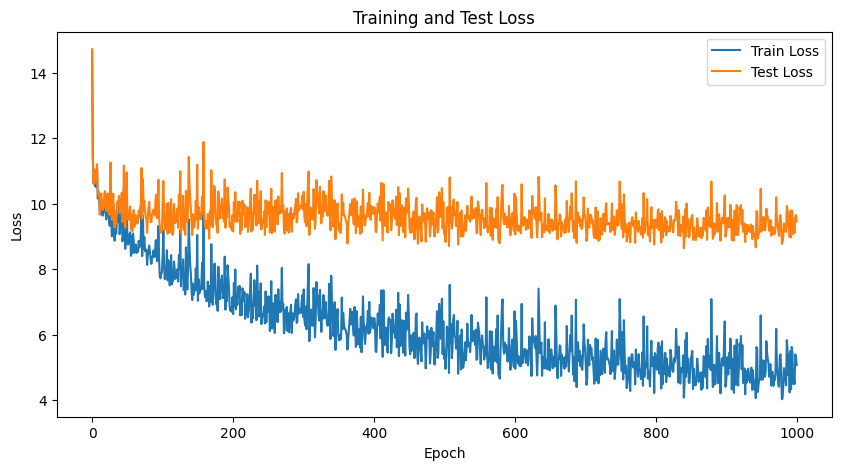

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')

plt.show()

Модель сильно подстраивается под таргет и из-за дропаута так сильно скачет лосс. Но необходимое значение RMSE для 10 баллов было достигнуто. Ниже проведем эксперименты с архитектурой и гиперпараметрами.  

Для начала изменим архитектуру модели, увеличив количество скрытых слоев

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

set_random_seed(42)

df = pd.read_csv('data.txt.zip', header=None)
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[:20000], y[:20000], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# применим минимакс скалер для таргета
scaler = MinMaxScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).T[0]
y_test = scaler.transform(y_test.reshape(-1, 1)).T[0]

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

input_size = X_train.shape[1]
output_size = 1

In [ ]:
import torch
import torch.nn as nn

class NeuralNet_2(nn.Module):
    def __init__(self, input_size, output_size: int=1):
        super(NeuralNet_2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 75),
            nn.BatchNorm1d(75),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(75, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

input_size = 90
model = NeuralNet_2(input_size)


In [ ]:
import torch.optim as optim


model = NeuralNet_2(input_size, output_size).to(device)

criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)


# просто функция для расчета RMSE для предикта и таргета, переведенных именно в года
my_loss = lambda y_pred, y_test: np.sqrt(np.mean((scaler.inverse_transform(y_pred.T[0].detach().numpy().reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1))) ** 2))

In [ ]:
# лень оформлять код в функцию, поэтому просто копия с ячеек выше

num_epochs = 1000
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_loss = my_loss(model(X_train), y_train)
        test_loss = my_loss(model(X_test), y_test)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


 10%|█         | 100/1000 [04:39<46:27,  3.10s/it]

Epoch [100/1000], Train Loss: 9.6577, Test Loss: 9.4967


 20%|██        | 200/1000 [10:01<58:59,  4.42s/it]

Epoch [200/1000], Train Loss: 10.0154, Test Loss: 9.8344


 30%|███       | 300/1000 [15:28<36:35,  3.14s/it]

Epoch [300/1000], Train Loss: 9.9691, Test Loss: 9.8220


 40%|████      | 400/1000 [20:38<30:55,  3.09s/it]

Epoch [400/1000], Train Loss: 9.9954, Test Loss: 9.7903


 50%|█████     | 500/1000 [25:48<26:22,  3.16s/it]

Epoch [500/1000], Train Loss: 9.8564, Test Loss: 9.6888


 60%|██████    | 600/1000 [30:55<20:35,  3.09s/it]

Epoch [600/1000], Train Loss: 10.2855, Test Loss: 10.1253


 70%|███████   | 700/1000 [36:03<15:28,  3.10s/it]

Epoch [700/1000], Train Loss: 10.2339, Test Loss: 10.0733


 80%|████████  | 800/1000 [41:06<09:40,  2.90s/it]

Epoch [800/1000], Train Loss: 10.0619, Test Loss: 9.8913


 90%|█████████ | 900/1000 [46:09<05:01,  3.02s/it]

Epoch [900/1000], Train Loss: 9.9514, Test Loss: 9.7960


100%|██████████| 1000/1000 [51:15<00:00,  3.08s/it]

Epoch [1000/1000], Train Loss: 10.0722, Test Loss: 9.8824


In [ ]:
min(test_losses)

9.110898971557617

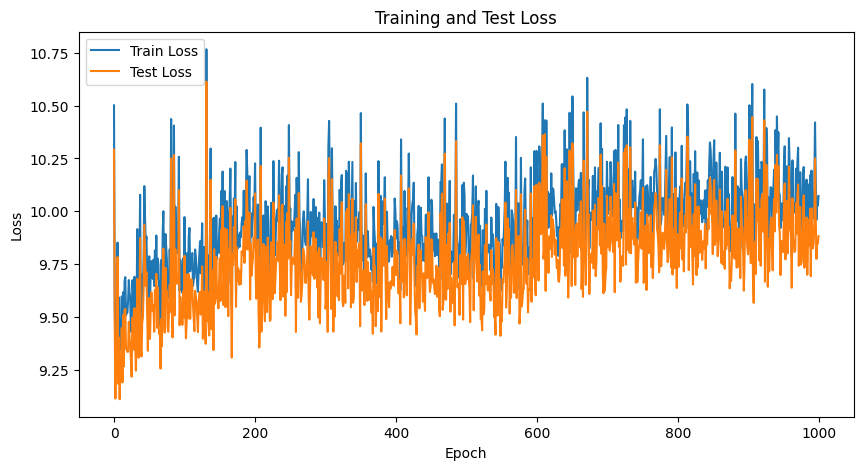

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')

plt.show()

Ну... результат не очень, так еще и учится ужасно долго, но как эксперимент сойдет

теперь изменим optimizer обратно на SGD, но будем использовать его для новой архитектуры

In [ ]:
import torch.optim as optim


model = NeuralNet_2(input_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)


# просто функция для расчета RMSE для предикта и таргета, переведенных именно в года
my_loss = lambda y_pred, y_test: np.sqrt(np.mean((scaler.inverse_transform(y_pred.T[0].detach().numpy().reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1))) ** 2))

In [ ]:
# лень оформлять код в функцию, поэтому просто копия с ячеек выше

num_epochs = 1000
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        train_loss = my_loss(model(X_train), y_train)
        test_loss = my_loss(model(X_test), y_test)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


 10%|█         | 100/1000 [00:53<06:55,  2.16it/s]

Epoch [100/1000], Train Loss: 8.6303, Test Loss: 8.7861


 20%|██        | 200/1000 [01:51<07:17,  1.83it/s]

Epoch [200/1000], Train Loss: 8.4148, Test Loss: 8.6997


 30%|███       | 300/1000 [02:43<05:24,  2.16it/s]

Epoch [300/1000], Train Loss: 7.8810, Test Loss: 8.5543


 40%|████      | 400/1000 [03:34<05:03,  1.98it/s]

Epoch [400/1000], Train Loss: 7.5023, Test Loss: 8.5048


 50%|█████     | 500/1000 [04:32<04:08,  2.01it/s]

Epoch [500/1000], Train Loss: 7.1693, Test Loss: 8.4895


 60%|██████    | 600/1000 [05:22<03:12,  2.08it/s]

Epoch [600/1000], Train Loss: 6.8922, Test Loss: 8.4543


 70%|███████   | 700/1000 [06:12<02:38,  1.89it/s]

Epoch [700/1000], Train Loss: 6.7377, Test Loss: 8.5302


 80%|████████  | 800/1000 [07:02<01:48,  1.84it/s]

Epoch [800/1000], Train Loss: 6.4160, Test Loss: 8.4576


 90%|█████████ | 900/1000 [07:53<00:50,  1.97it/s]

Epoch [900/1000], Train Loss: 6.2505, Test Loss: 8.4368


100%|██████████| 1000/1000 [08:44<00:00,  1.91it/s]

Epoch [1000/1000], Train Loss: 6.1341, Test Loss: 8.4527


In [ ]:
min(test_losses)

8.36953353881836

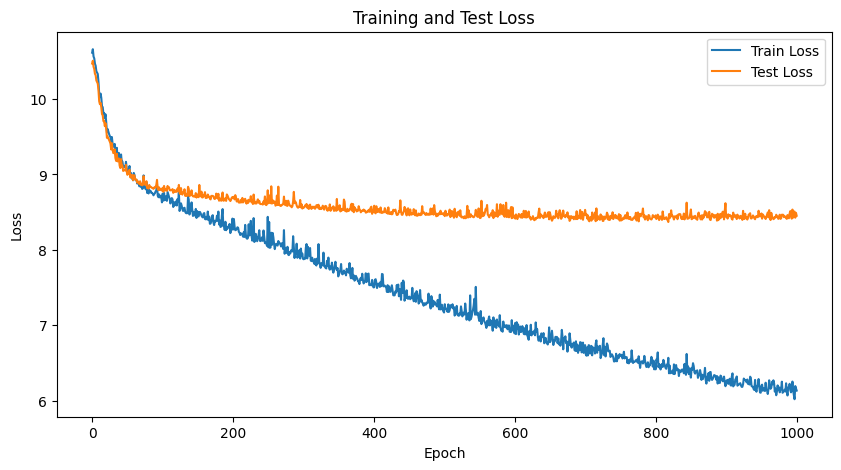

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')

plt.show()

Ну все, дальше можне не экспериментировать (тем более, что 3 эксперимента есть). Видно, что SGD, намного лучше сходится. Хотя все равно есть сильное переобучение под траин выборку

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

данный мем наглядно показывает мои попытки добится текущего результата:

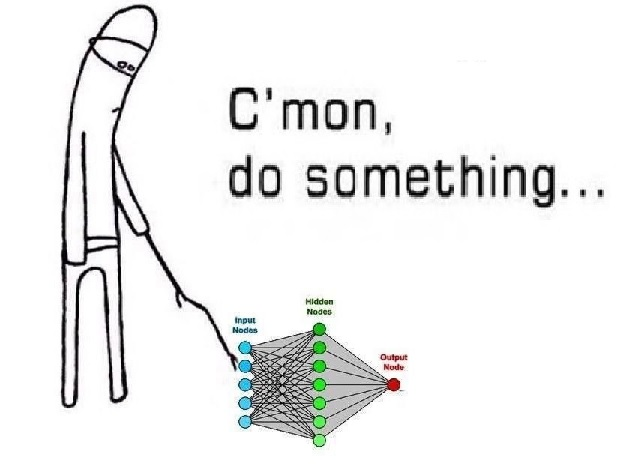

Для архитектуры выведем саммари по двум используемым моделям. А логика в использовании именно таких архитектур была в следующем. Так как у нас довольно много фичей (90), то было два варианта: вытянуть в еще больший скрытый слой данне вектора и потом постепенно их уменьшать или сразу их медленно уменьшать. Второй вариант дал результат лучше (причем даже параметров в сети было меньше, чем в первой), так как скорее всего при резком увеличении размерности в первом часть информации об объекте могла исказиться.

Сами графики метрик в зависимости от эпохи были показаны выше; гиперпараметры также можно найти в соответсвующих ячейках, добавлю лишь, что увеличение learning rate'а значительно увеличило результат и скорость обучения.

In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

In [ ]:
from torchinfo import summary


# для первой архитектуры
summary(model=model,
        input_size=[batch_size, input_size],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
NeuralNet (NeuralNet)                    [128, 90]            [128, 1]             --                   True
├─Sequential (block)                     [128, 90]            [128, 1]             --                   True
│    └─Linear (0)                        [128, 90]            [128, 180]           16,380               True
│    └─ReLU (1)                          [128, 180]           [128, 180]           --                   --
│    └─LayerNorm (2)                     [128, 180]           [128, 180]           360                  True
│    └─Linear (3)                        [128, 180]           [128, 360]           65,160               True
│    └─ReLU (4)                          [128, 360]           [128, 360]           --                   --
│    └─LayerNorm (5)                     [128, 360]           [128, 360]           720                  True
│    └─Dropout (6)

In [ ]:
# для второй архитектуры

summary(model=model,
        input_size=[batch_size, input_size],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
NeuralNet_2 (NeuralNet_2)                [128, 90]            [128, 1]             --                   True
├─Sequential (model)                     [128, 90]            [128, 1]             --                   True
│    └─Linear (0)                        [128, 90]            [128, 75]            6,825                True
│    └─BatchNorm1d (1)                   [128, 75]            [128, 75]            150                  True
│    └─ReLU (2)                          [128, 75]            [128, 75]            --                   --
│    └─Dropout (3)                       [128, 75]            [128, 75]            --                   --
│    └─Linear (4)                        [128, 75]            [128, 64]            4,864                True
│    └─BatchNorm1d (5)                   [128, 64]            [128, 64]            128                  True
│    └─ReLU (6)   